# Partie 1

## 1. Collecte de données

### 1.1 Est-ce que le ratissage des annonces sur le site web que vous avez choisi est permis ? Justifier votre réponse.

In [2]:

import requests
from fake_useragent import UserAgent

ua = UserAgent()

BASE_HTTP = "https://"
URL_DUPROPIO = "duproprio.com"
URL_PUBLIMAI = "www.publimaison.ca"
robots = "/robots.txt"
headers = {
    "User-Agent": f"{ua.random}",
}
response = requests.get(BASE_HTTP + URL_DUPROPIO + robots, headers=headers)
print("duproprio/robots.txt", response.text)

duproprio/robots.txt User-agent: *
Disallow: /email-consent/
Disallow: /facebook/
Disallow: /file/
Disallow: /files/
Disallow: /filesystem/
Disallow: /listing/comparables/
Disallow: /listing/comparable-get-html/
Disallow: /listing/evaluateur-get-html/
Disallow: /listing/modelo/
Disallow: /listing/modelo-get-html/
Disallow: /listing/print/
Disallow: /listing/print-pdf/
Disallow: /listing/report-validate-page
Disallow: /logout
Disallow: /maintenances/
Disallow: /modal/
Disallow: /modelo/
Disallow: /my-account/
Disallow: /pdf-report/
Disallow: /services/
Disallow: /unsupported-browser
Disallow: /util/
Disallow: /validate_dossier.php
Disallow: /webservice/
Disallow: /82591175/
Disallow: /9289347/
Disallow: /browse/listings/all
Disallow: /agent
Disallow: /agents
Disallow: /fr-ca/rest
Disallow: /en-ca/rest
Disallow: /fr-ca/api
Disallow: /en-ca/api
Disallow: /fr/moncompte
Disallow: /en/myaccount

Allow: /*/api-proxy/infosession
Allow: /*/api-proxy/featured-homes
Disallow: /*/api-proxy

Sitema

In [3]:
response = requests.get(BASE_HTTP + URL_PUBLIMAI + robots)
print("publimaison/robots.txt", response.text)

publimaison/robots.txt User-agent: *
Disallow: /fr/achatactivated/
Disallow: /fr/achat/
Disallow: /fr/ajaxrecherche/
Disallow: /fr/alertes/
Disallow: /fr/annoncecreation/
Disallow: /fr/bannieresys/
Disallow: /fr/caisse/
Disallow: /fr/desjardins/
Disallow: /fr/documents/
Disallow: /fr/emprunt/
Disallow: /fr/envoiecourriel/
Disallow: /fr/favoris/
Disallow: /fr/forfait/
Disallow: /fr/gestion*
Disallow: /fr/indicemarche/
Disallow: /fr/listestatistique/
Disallow: /fr/monprofil/
Disallow: /fr/monprofilcourtier/
Disallow: /fr/panier/
Disallow: /fr/promouvoir/
Disallow: /fr/publicite/
Disallow: /fr/sondage/
Disallow: /fr/statistique/
Disallow: /fr/tauxhypothecaire/
Disallow: /fr/statcounter/
Disallow: /fr/Membre/ActivationCompte
Disallow: /fr/Annonce/RafraichirExpiration
Disallow: /fr/transfertcentris/*
Disallow: /en/achatactivated/
Disallow: /en/achat/
Disallow: /en/ajaxrecherche/
Disallow: /en/alertes/
Disallow: /en/annoncecreation/
Disallow: /en/bannieresys/
Disallow: /en/caisse/
Disallow: 

### 1.2 Vous devez extraire dans un fichier .csv a remettre, l’ensemble des annonces (lancer la recherche sans aucun critere)

In [122]:
def extract_characteristics(soup):
    bedrooms = bathrooms = half_baths = floors = living_space = lot_size = None
    characteristics = soup.find('div', class_='listing-main-characteristics')
    if characteristics:
        for item in characteristics.find_all('div', recursive=False):
            label = item.find("div", class_="listing-main-characteristics__label")
            if label:
                title = label.find("span", class_="listing-main-characteristics__title").get_text(strip=True).lower()
                number = label.find("span", class_="listing-main-characteristics__number").get_text(strip=True)
                if "chambre" in title:
                    bedrooms = number
                elif "bain" in title:
                    bathrooms = number
                elif "eau" in title:
                    half_baths = number
                elif "étage" in title:
                    floors = number
        if living_space_element := characteristics.find('div',
                                                        class_='listing-main-characteristics__item--living-space-area'):
            living_space = living_space_element.find('span',
                                                     class_='listing-main-characteristics__number--dimensions').get_text(
                strip=True)

        if lot_size_element := characteristics.find('div', class_='listing-main-characteristics__item--lot-dimensions'):
            lot_size = lot_size_element.find('span',
                                             class_='listing-main-characteristics__number--dimensions').get_text(
                strip=True)

    return bedrooms, bathrooms, half_baths, floors, living_space, lot_size


def extract_mortgage(soup):
    mortgage_div = soup.find("div", class_="mortgage-data__table")
    city_taxes = school_taxes = electricity = insurance = None
    if mortgage_div:
        rows = mortgage_div.find_all("div", class_="mortgage-data__table__row")
        for row in rows:
            name_item = row.find("div", class_="mortgage-data__table__row__item--name")
            if name_item:
                name = name_item.get_text(strip=True).lower()
                value = row.find("div", class_="mortgage-data__table__row__item--yearly-costs").get_text(strip=True)
                if "taxes municipales" in name:
                    city_taxes = value
                elif "taxes scolaires" in name:
                    school_taxes = value
                elif "électricité" in name:
                    electricity = value
                elif "assurances" in name:
                    insurance = value
    return city_taxes, school_taxes, electricity, insurance


def extract_data_from_item(response):
    soup = BeautifulSoup(response.text, "html.parser")
    address_div = soup.find("div", class_="listing-location__address")
    address = address_div.find("h1").get_text(strip=True) if address_div and address_div.find("h1") else None
    city = address_div.find_all("span")[0].get_text(strip=True) if address_div and len(
        address_div.find_all("span")) > 0 else None
    region = address_div.find_all("span")[1].get_text(strip=True) if address_div and len(
        address_div.find_all("span")) > 1 else None
    price_div = soup.find("div", class_='listing-price__amount')
    price = price_div.get_text(strip=True) if price_div else None
    bedrooms, bathrooms, half_baths, floors, living_space, lot_size = extract_characteristics(soup)
    city_taxes, school_taxes, electricity, insurance = extract_mortgage(soup)
    return {
        "Adresse": address,
        "Prix": price,
        "Ville": city,
        "Région": region,
        "Chambres": bedrooms,
        "Salles de bain": bathrooms,
        "Salles d'eau": half_baths,
        "Étages": floors,
        "Aire habitable": living_space,
        "Taille terrain": lot_size,
        "Taxes municipales": city_taxes,
        "Taxes scolaires": school_taxes,
        "Électricité": electricity,
        "Assurances": insurance
    }

In [129]:
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
import logging
import pandas as pd
import traceback

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
columns = ["Adresse", "Prix", "Ville", "Région", "Chambres", "Salles de bain", "Salles d'eau", "Étages",
           "Aire habitable", "Taille terrain", "Taxes municipales", "Taxes scolaires", "Électricité", "Assurances"]
filename = "../data/duproprio.csv"
scrap_data = []
session = requests.Session()
session.headers.update(headers)

try:
    logging.info("Début de la collecte des données")
    for page_number in tqdm(range(1, 714), desc="Pages", leave=True):
        url = f"https://duproprio.com/fr/rechercher/liste?search=true&parent=1&pageNumber={page_number}&sort=-published_at"
        response = session.get(url, headers=headers)
        if response.status_code != 200:
            logging.error(f"Erreur lors de la requete {url} : {response.status_code}")
            break
        soup = BeautifulSoup(response.text, "html.parser")
        listings = soup.find_all("li", class_="search-results-listings-list__item")
        for item in listings:
            if "ad-zone" in item.get("class", []):
                continue
            url = item.find("a", class_="search-results-listings-list__item-image-link").get("href")
            response = session.get(url, headers=headers)
            scrap_data.append(extract_data_from_item(response))
    logging.info("Fin de la collecte des données")
except Exception as e:
    logging.error(f"Erreur : {e} \n {traceback.format_exc()}")

if len(scrap_data):
    try:
        logging.info("Début de l'écriture des données")
        df = pd.DataFrame(scrap_data, columns=columns)
        df.to_csv(filename, index=False)
        logging.info("Fin de l'écriture des données")
    except Exception as e:
        logging.error(f"Erreur : {e}")


2023-11-15 01:39:57,797 - INFO - Début de la collecte des données


Pages:   0%|          | 0/713 [00:00<?, ?it/s]

2023-11-15 02:36:41,433 - INFO - Fin de la collecte des données
2023-11-15 02:36:41,435 - INFO - Début de l'écriture des données
2023-11-15 02:36:41,568 - INFO - Fin de l'écriture des données


## 2. Nettoyage et exploration des donnees
### 2.1 Combien ya-t-il de valeurs manquantes dans chaque colonne de votre jeu de donn´ees?

In [21]:
import pandas as pd

df = pd.read_csv('../data/duproprio.csv')
df.isnull().sum()

Adresse               285
Prix                   68
Ville                   0
Région                  0
Chambres             1378
Salles de bain       1452
Salles d'eau         5036
Étages               2093
Aire habitable       2444
Taille terrain       1359
Taxes municipales    2170
Taxes scolaires      2564
Électricité          4126
Assurances           5241
dtype: int64

### 2.2 Selon vous, quel est la cause de ces valeurs manquantes ? Est-ce que parmi les colonnes qui ont des valeurs manquantes, on pourrait utiliser l’une des techniques de remplacement de valeurs manquantes vues en cours ? Si oui dites pour les colonnes concern´ees, lesquelles des techniques fonctionneraient bien


In [22]:
df.isnull().sum().apply(lambda x: x / df.shape[0] * 100)

Adresse               3.637524
Prix                  0.867900
Ville                 0.000000
Région                0.000000
Chambres             17.587747
Salles de bain       18.532227
Salles d'eau         64.275686
Étages               26.713465
Aire habitable       31.193363
Taille terrain       17.345246
Taxes municipales    27.696235
Taxes scolaires      32.724952
Électricité          52.661136
Assurances           66.892151
dtype: float64

### 2.3 Combien ya til de r´egions diff´erentes ? et de villes diff´erentes ?

In [23]:
unique_regions = df["Région"].unique()
print(f"Nombre de regions differentes : {len(unique_regions)}")
unique_cities = df["Ville"].unique()
print(f"Nombre de villes differentes : {len(unique_cities)}")

Nombre de regions differentes : 21
Nombre de villes differentes : 993


### 2.4 Quel est le type (inf´er´e par pandas) de donn´ees de chaque colonne ?

In [24]:
df.dtypes

Adresse               object
Prix                  object
Ville                 object
Région                object
Chambres             float64
Salles de bain       float64
Salles d'eau         float64
Étages               float64
Aire habitable        object
Taille terrain        object
Taxes municipales     object
Taxes scolaires       object
Électricité           object
Assurances            object
dtype: object

### 2.5 Nettoyer vos donn´ees : correction d’erreurs, traitement de valeurs manquantes s’il ya lieu, correction du type des donn´ees.

In [25]:
df.dtypes

Adresse               object
Prix                  object
Ville                 object
Région                object
Chambres             float64
Salles de bain       float64
Salles d'eau         float64
Étages               float64
Aire habitable        object
Taille terrain        object
Taxes municipales     object
Taxes scolaires       object
Électricité           object
Assurances            object
dtype: object

In [26]:
import re


def convert_price(value):
    if pd.isna(value):
        return np.nan
    if isinstance(value, float):
        return value
    try:
        return float(value.replace("$", "").replace('\xa0', '').replace(',', '.').strip())
    except ValueError:
        return np.nan


def convert_surface(value):
    if pd.isna(value):
        return np.nan
    if isinstance(value, float):
        return value
    try:
        value = value.replace(' ', '')
        if 'x' in value or 'X' in value:
            m2 = re.search(r'(\d+(\.\d+)?)\s*[xX]\s*(\d+(\.\d+)?)\s*[mM]', value)

            if m2:
                return float(m2.group(1)) * float(m2.group(3))

        m2 = re.search(r'(\d+(\.\d+)?)\s*[mM]', value)
        if m2:
            return float(m2.group(1))

        acres = re.search(r'(\d+(\.\d+)?)\s*acre', value, re.IGNORECASE)
        if acres:
            return float(acres.group(1)) * 4046.86

        hectares = re.search(r'(\d+(\.\d+)?)\s*hectare', value, re.IGNORECASE)
        if hectares:
            return float(hectares.group(1)) * 10000

    except ValueError:
        return np.nan


In [27]:
import pandas as pd

df = pd.read_csv('../data/duproprio.csv')

df['Adresse'].fillna('', inplace=True)

df['Prix'] = df['Prix'].apply(convert_price)
df['Taxes municipales'] = df['Taxes municipales'].apply(convert_price)
df['Taxes scolaires'] = df['Taxes scolaires'].apply(convert_price)
df['Électricité'] = df['Électricité'].apply(convert_price)
df['Assurances'] = df['Assurances'].apply(convert_price)

df['Taille terrain'] = df['Taille terrain'].apply(convert_surface)
df['Aire habitable'] = df['Aire habitable'].apply(convert_surface)



In [28]:
print(df["Taille terrain"].isna().sum())
print(df["Aire habitable"].isna().sum())

1374
2444


In [29]:
df[(df["Aire habitable"].isna() | df["Taille terrain"].isna())]

,Adresse,Prix,Ville,Région,Chambres,Salles de bain,Salles d'eau,Étages,Aire habitable,Taille terrain,Taxes municipales,Taxes scolaires,Électricité,Assurances
1,", boulevard Montseigneur-de-Laval",350000.0,Baie-St-Paul,Charlevoix,NaN,NaN,NaN,NaN,NaN,194298.00,359.1,200.0,NaN,NaN
2,"404-1420, rue Gaston-Véronneau",284000.0,Longueuil (Vieux-Longueuil),Montérégie (Rive-Sud Montréal),1.0,1.0,1.0,1.0,61.04,NaN,1797.0,175.0,NaN,NaN
4,"744-746, rue Louis-H Desjardins",635000.0,Terrebonne (Terrebonne),Lanaudière,5.0,3.0,NaN,NaN,NaN,109.98,4257.0,352.0,NaN,NaN
9,Unité 506 - 7480 Boulevard Taschereau,658900.0,Brossard,Montérégie (Rive-Sud Montréal),3.0,2.0,NaN,1.0,109.25,NaN,NaN,NaN,NaN,NaN
10,"63, rue de Bellevue",475000.0,Blainville,Laurentides,NaN,NaN,NaN,NaN,NaN,752.50,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7825,", boulevard Montseigneur-de-Laval",350000.0,Baie-St-Paul,Charlevoix,NaN,NaN,NaN,NaN,NaN,194298.00,359.1,200.0,NaN,NaN
7826,"404-1420, rue Gaston-Véronneau",284000.0,Longueuil (Vieux-Longueuil),Montérégie (Rive-Sud Montréal),1.0,1.0,1.0,1.0,61.04,NaN,1797.0,175.0,NaN,NaN
7828,"744-746, rue Louis-H Desjardins",635000.0,Terrebonne (Terrebonne),Lanaudière,5.0,3.0,NaN,NaN,NaN,109.98,4257.0,352.0,NaN,NaN
7833,Unité 506 - 7480 Boulevard Taschereau,658900.0,Brossard,Montérégie (Rive-Sud Montréal),3.0,2.0,NaN,1.0,109.25,NaN,NaN,NaN,NaN,NaN


In [30]:
df[df.duplicated()]

,Adresse,Prix,Ville,Région,Chambres,Salles de bain,Salles d'eau,Étages,Aire habitable,Taille terrain,Taxes municipales,Taxes scolaires,Électricité,Assurances
2614,"656-700, Chemin de la Côte S du Lac Vert",NaN,St-Nérée,Chaudière-Appalaches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4392,"1285, boulevard Arthur-Sauvé",52.0,Laval-Ouest,Laval,NaN,NaN,NaN,NaN,NaN,4065.7200,NaN,NaN,NaN,NaN
4627,rang de Bellechasse,45000.0,St-Magloire-De-Bellechasse,Chaudière-Appalaches,NaN,NaN,NaN,NaN,NaN,15000.0000,NaN,NaN,NaN,NaN
4894,"234, rue de la Station",199500.0,Armagh,Chaudière-Appalaches,5.0,NaN,NaN,NaN,NaN,3716.1200,1400.00,NaN,200.0,NaN
5091,rue du Geai-Bleu,298000.0,St-Apollinaire,Chaudière-Appalaches,5.0,1.0,1.0,2.0,130.81,418.0600,NaN,NaN,NaN,NaN
5434,Rue des Iris,NaN,Victoriaville,Centre-du-Québec,2.0,1.0,NaN,1.0,98.85,1486.4500,NaN,NaN,NaN,NaN
5574,rang Sainte-Anne,41500.0,La Malbaie (St-Fidèle),Charlevoix,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5796,"859, chemin Parent",209000.0,La Pêche (Duclos),Outaouais,NaN,NaN,NaN,NaN,NaN,445154.6000,NaN,NaN,NaN,NaN
6748,"1164, route Henderson",35000.0,St-Malachie,Chaudière-Appalaches,NaN,NaN,NaN,NaN,NaN,2800.0000,333.32,NaN,NaN,NaN
7791,"1952, rue des Tulipes",359000.0,Jonquière (Jonquière),Saguenay-Lac-Saint-Jean,3.0,2.0,NaN,1.0,85.21,1040.0500,NaN,NaN,NaN,NaN


In [31]:
df = df.drop_duplicates(subset=['Adresse'], keep='first')
df[df.duplicated()]

,Adresse,Prix,Ville,Région,Chambres,Salles de bain,Salles d'eau,Étages,Aire habitable,Taille terrain,Taxes municipales,Taxes scolaires,Électricité,Assurances


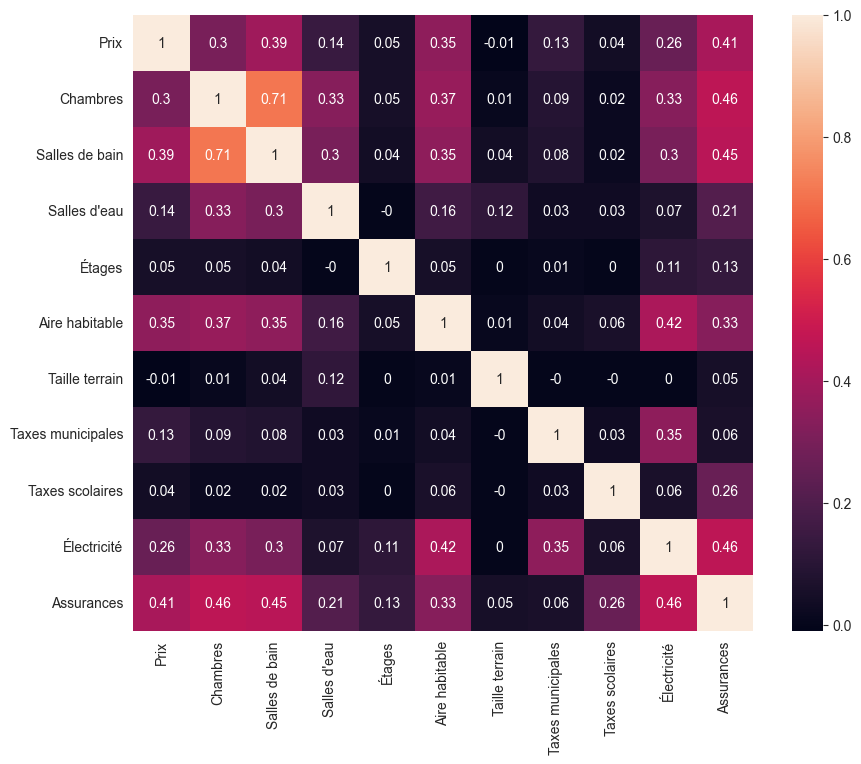

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_df = df.select_dtypes(include=['float64'])

correlation_matrix = numeric_df.corr().round(2)

plt.figure(figsize=(10, 8))
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

In [33]:
df.isnull().sum().apply(lambda x: x / df.shape[0] * 100)

Adresse               0.000000
Prix                  0.719327
Ville                 0.000000
Région                0.000000
Chambres             17.494571
Salles de bain       18.485342
Salles d'eau         64.237242
Étages               26.886536
Aire habitable       31.392508
Taille terrain       17.290988
Taxes municipales    23.832790
Taxes scolaires      29.044517
Électricité          49.904995
Assurances           65.010858
dtype: float64

In [34]:
import numpy as np


# Maison : Aire habitable, Taille terrain, Chambres, Salles de bain
# Appartement : Aire habitable, Chambres, Salles de bain
# Terrain : Taille terrain
def categorize_property_type(row):
    if not pd.isna(row['Aire habitable']) and not pd.isna(row['Taille terrain']) and (not pd.isna(
            row['Chambres']) or not pd.isna(row['Salles de bain'])):
        return 'Maison'
    elif not pd.isna(row['Aire habitable']) and (not pd.isna(row['Chambres']) or not pd.isna(row['Salles de bain'])):
        return 'Appartement'
    elif not pd.isna(row['Taille terrain']):
        return 'Terrain'
    else:
        return np.nan


df["Type"] = df.apply(categorize_property_type, axis=1)


In [35]:
df[df["Type"].isna()]

,Adresse,Prix,Ville,Région,Chambres,Salles de bain,Salles d'eau,Étages,Aire habitable,Taille terrain,Taxes municipales,Taxes scolaires,Électricité,Assurances,Type
323,"10-124, rue Lapointe",299000.0,Repentigny (Repentigny),Lanaudière,2.0,1.0,NaN,1.0,NaN,NaN,1711.05,115.92,NaN,NaN,NaN
335,chemin du Gouverneur Duquesne,235000.0,Rivière-à-Pierre,Portneuf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
427,100 chemin des Diligences,619900.0,Bromont,Estrie,2.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
480,"1770, rue du Fief",89000.0,Trois-Rivières (Trois-Rivières),Mauricie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
486,"653, rue Anne-Hébert",615000.0,Terrebonne (Terrebonne),Lanaudière,3.0,1.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7612,"925, rang 4e Ouest",1799000.0,St-Simon-De-Bagot,Montérégie (Rive-Sud Montréal),4.0,2.0,1.0,2.0,NaN,NaN,3183.00,1203.00,NaN,NaN,NaN
7630,"4654, rue des Samares",399990.0,Charlesbourg,Québec Rive-Nord,2.0,1.0,1.0,2.0,NaN,NaN,2281.00,434.00,95.0,59.0,NaN
7695,"162, rue Harold",595000.0,Gatineau (Gatineau),Outaouais,5.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7761,"7, rue Lafrance",499000.0,Déléage,Outaouais,NaN,NaN,NaN,NaN,NaN,NaN,3943.56,NaN,NaN,NaN,NaN


In [36]:
before = df.shape[0]
df = df.dropna(subset=['Type'])
after = df.shape[0]
print(f"Nombre de lignes supprimees : {before - after}")

Nombre de lignes supprimees : 150


In [37]:
df = df.astype({"Chambres": "Int64", "Salles de bain": "Int64", "Salles d'eau": "Int64", "Étages": "Int64"})

df.loc[df["Type"] == "Terrain", ["Chambres", "Salles de bain", "Salles d'eau", "Étages", "Aire habitable", "Assurances",
                                 "Électricité"]] = 0

df.loc[df["Type"] == "Appartement", ["Taille terrain"]] = 0

df["Chambres"].fillna(df.groupby("Type")["Chambres"].transform("median"), inplace=True)
df["Salles de bain"].fillna(df.groupby("Type")["Salles de bain"].transform("median"), inplace=True)
df["Étages"].fillna(df.groupby("Type")["Étages"].transform("median"), inplace=True)
df["Taxes municipales"].fillna(df.groupby("Type")["Taxes municipales"].transform("median"), inplace=True)
df["Taxes scolaires"].fillna(df.groupby("Type")["Taxes scolaires"].transform("median"), inplace=True)
df["Électricité"].fillna(df.groupby("Type")["Électricité"].transform("median"), inplace=True)
df["Assurances"].fillna(df.groupby("Type")["Assurances"].transform("median"), inplace=True)

df["Salles d'eau"].fillna(0, inplace=True)

before_rm = df.shape[0]
df.dropna(subset=["Prix"], inplace=True)
after_rm = df.shape[0]
print(f"Nombre de lignes supprimees : {before_rm - after_rm}")

Nombre de lignes supprimees : 41


In [38]:
# Modele de regression de remplacment realiser avant que je decide d'ajouter la colonne type
from sklearn.linear_model import LinearRegression

bedrooms = df[df["Chambres"].notna()]
bedrooms_na = df[df["Chambres"].isna()]

X = bedrooms[["Salles de bain"]]
y = bedrooms["Chambres"]

model_bedrooms = LinearRegression()
model_bedrooms.fit(X, y)

X_missing = bedrooms_na[["Salles de bain"]]
predicted_chambres = model_bedrooms.predict(X_missing)
predicted_chambres = predicted_chambres.round().astype(int)
df.loc[df["Chambres"].isna(), "Chambres"] = predicted_chambres

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LinearRegression.

In [39]:
df.isnull().sum().apply(lambda x: x / df.shape[0] * 100)

Adresse              0.0
Prix                 0.0
Ville                0.0
Région               0.0
Chambres             0.0
Salles de bain       0.0
Salles d'eau         0.0
Étages               0.0
Aire habitable       0.0
Taille terrain       0.0
Taxes municipales    0.0
Taxes scolaires      0.0
Électricité          0.0
Assurances           0.0
Type                 0.0
dtype: float64

### 2.6 Quel est le prix moyen des maisons (au moins 1 chambre et 1 salle de bain) sur l’ˆıle de Montr´eal ? A Laval ? Dans les laurentides ?

In [40]:
regions = df["Région"].unique()
print(f"Regions : {regions}")

Regions : ['Saguenay-Lac-Saint-Jean' 'Charlevoix' 'Montérégie (Rive-Sud Montréal)'
 'Lanaudière' 'Bas-Saint-Laurent' 'Estrie' 'Québec Rive-Sud (Lévis)'
 'Laurentides' 'Outaouais' "Montréal / l'Île" 'Québec Rive-Nord'
 'Centre-du-Québec' 'Laval' 'Chaudière-Appalaches' 'Mauricie'
 'Gaspésie-Îles-de-la-Madeleine' 'Portneuf' 'Montérégie Ouest'
 'Abitibi-Témiscamingue' 'Côte-Nord' 'Nord-du-Québec']


In [41]:
mask_houses = (df["Chambres"] >= 1) & (df["Salles de bain"] >= 1)

avg_price_montreal = df[(df["Région"] == "Montréal / l'Île") & mask_houses]["Prix"].mean()
avg_price_laval = df[(df["Région"] == "Laval") & mask_houses]["Prix"].mean()
avg_price_laurentides = df[(df["Région"] == "Laurentides") & mask_houses]["Prix"].mean()

print(f"Prix moyen des maisons sur l'ile de Montreal : {avg_price_montreal}")
print(f"Prix moyen des maisons a Laval : {avg_price_laval}")
print(f"Prix moyen des maisons dans les laurentides : {avg_price_laurentides}")

Prix moyen des maisons sur l'ile de Montreal : 617155.0657939914
Prix moyen des maisons a Laval : 630601.475
Prix moyen des maisons dans les laurentides : 663159.8872545455


### 2.7 Dans quelle ville de Montr´eal/l’Ile les maisons (au moins 1 chambre et 1 salle de bain) coˆutent le moins chers ?

In [42]:
mask_houses_montreal = (df["Région"] == "Montréal / l'Île") & mask_houses

avg_price_by_city = df[mask_houses_montreal].groupby("Ville")["Prix"].mean()

cheaper_city = avg_price_by_city.idxmin()
avg_cheaper_city = avg_price_by_city.min()

print(f"Ville la moins chere : {cheaper_city}")
print(f"Prix moyen des maisons dans la ville la moins chere : {avg_cheaper_city}")

Ville la moins chere : Pointe-Aux-Trembles / Montréal-Est
Prix moyen des maisons dans la ville la moins chere : 451905.2631578947


### 2.8 Pour chaque r´egion, afficher le prix de l’item (annonce) le plus ´elev´e et la ville o`u l’item se situe. Ici on ne fait pas de diff´erence si c’est un condo/appartement, maison, terrain vide, etc. A quel r´egion/ville revient la palme d’or de l’item le plus cher ? Donner toutes les caract´eristiques (valeurs de toutes les colonnes) de cet item.

In [52]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)

In [54]:
most_expensive_item_region = df.loc[df.groupby("Région")["Prix"].idxmax()]
print("Item le plus cher par région :")
print(most_expensive_item_region[["Région", "Ville", "Adresse", "Prix"]])

print("\nItem le plus cher :")
most_expensive_item = df.loc[df["Prix"].idxmax()]
print(most_expensive_item)

Item le plus cher par région :
                              Région                               Ville                           Adresse       Prix
200            Abitibi-Témiscamingue                          Senneterre                   550, 10e Avenue  1200000.0
3958               Bas-Saint-Laurent   Rimouski (Ste-Odile-Sur-Rimouski)           137, chemin des Pointes  1750000.0
222                 Centre-du-Québec                     St-Pie-De-Guire                      195, 6e Rang  5200000.0
3033                      Charlevoix                     Les Éboulements    438, chemin Catherine-Delzenne  2585000.0
4318            Chaudière-Appalaches                           St-Julien                547, chemin Lehoux  6500000.0
895                        Côte-Nord                           Sept-Iles               600, avenue Cartier  1200000.0
4304                          Estrie                              Granby  971-993, rue Henry-Carleton-Monk  3300000.0
6544   Gaspésie-Îles-de-l

## 3 Visualisation et analyse des donn´ees
### 3.1  Pr´esenter visuellement (`a l’aide d’un graphique) la matrice de corr´elation entre les colonnes num´eriques. Y a-t-il des corr´elations de plus de 0.7 ? quelles sont elles ?

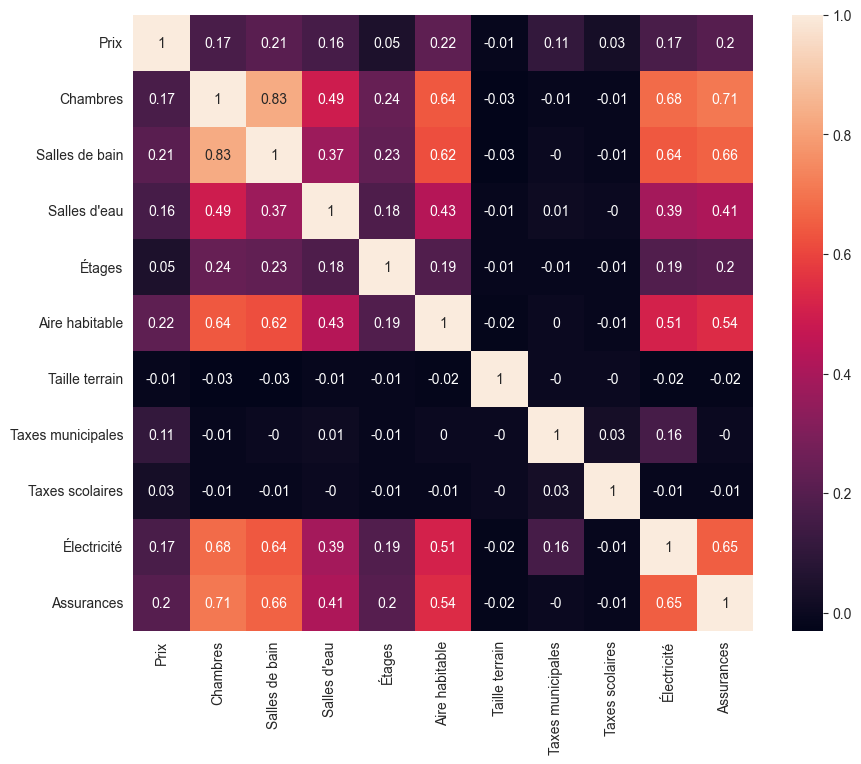

Correlation superieur a 0.7 :
 Chambres        Salles de bain    0.83
                Assurances        0.71
Salles de bain  Chambres          0.83
Assurances      Chambres          0.71
dtype: float64


In [57]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numeric_df.corr().round(2)

plt.figure(figsize=(10, 8))
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

correlation_target = abs(correlation_matrix.unstack())
print("Correlation superieur a 0.7 :\n", correlation_target[(correlation_target > 0.7) & (correlation_target != 1)])


### 3.2 Pr´esenter visuellement la proportion num´erique de chaque r´egion en ma de nombre d’annonces, par rapport a` l’ensemble des annonces. Quelle r´egion occupe la plus petite proportion ?

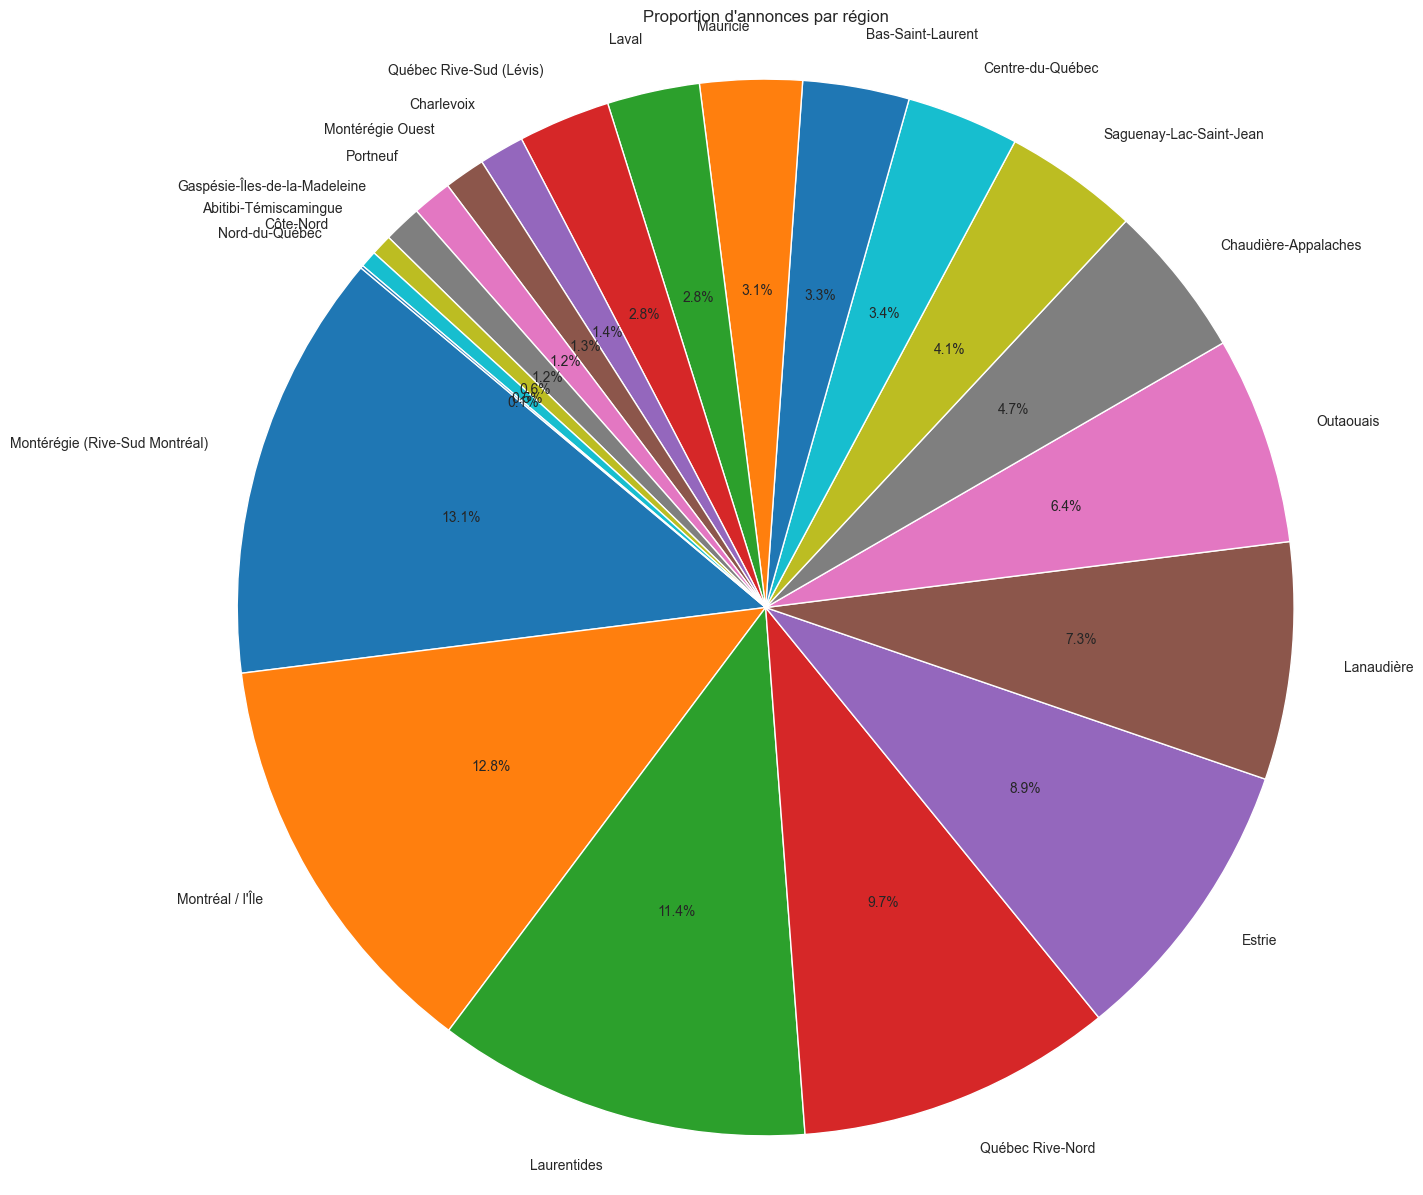

Région avec la plus petite proportion : Nord-du-Québec


In [59]:
items_by_region = df["Région"].value_counts()
proportion_by_region = items_by_region / items_by_region.sum() * 100

df_proportions = pd.DataFrame({'Région': proportion_by_region.index, 'Proportion': proportion_by_region.values})

plt.figure(figsize=(15, 15))
plt.pie(proportion_by_region, labels=proportion_by_region.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title("Proportion d'annonces par région")
plt.show()

print(f"Région avec la plus petite proportion : {proportion_by_region.idxmin()}")

### 3.3 A l’aide d’un graphique diff´erent de celui de la question pr´ec´edente, comparer le nombre d’annonces de vente pour chaque r´egion. Quelle r´egion poss`ede le plus d’annonces de vente ?

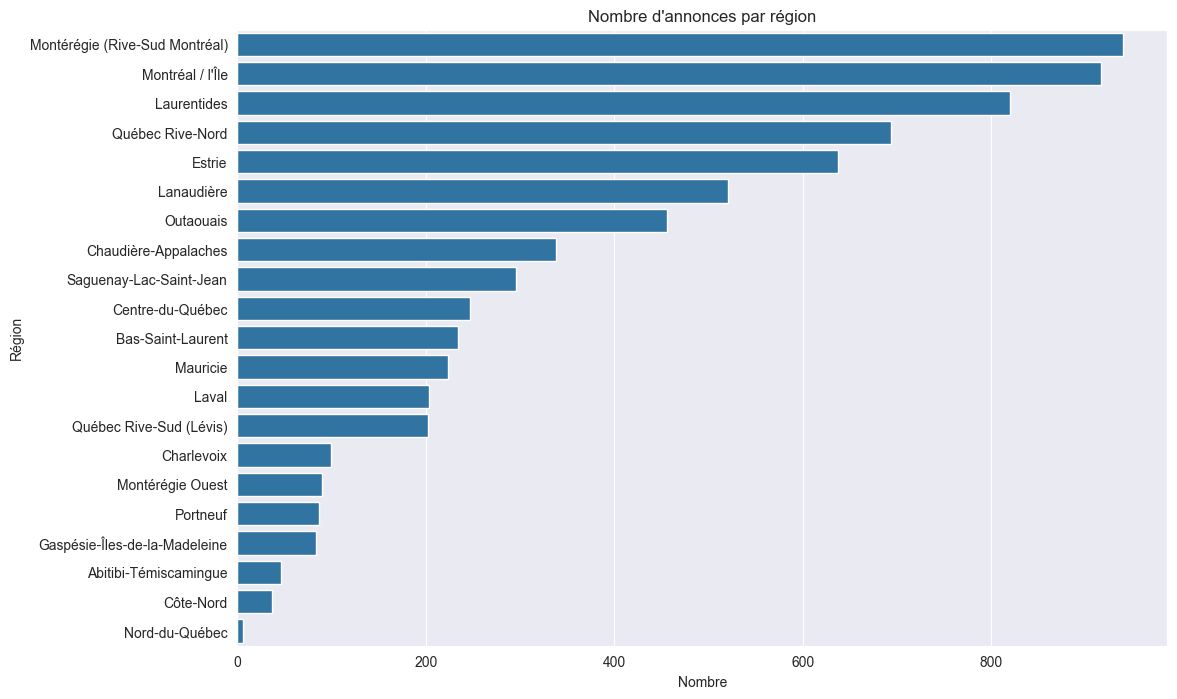

Région avec le plus d'annonces : Montérégie (Rive-Sud Montréal)


In [60]:
df_items_by_region = pd.DataFrame({'Région': items_by_region.index, 'Nombre': items_by_region.values})

plt.figure(figsize=(12, 8))
sns.barplot(x='Nombre', y='Région', data=df_items_by_region)
plt.title("Nombre d'annonces par région")
plt.xlabel("Nombre")
plt.ylabel("Région")
plt.show()

print(f"Région avec le plus d'annonces : {items_by_region.idxmax()}")


### 3.4 A l’aide d’un graphique, comparer le prix moyen des annonces pour chaque r´egion. Quelle r´egion poss`ede le prix moyen le plus ´elev´e ?

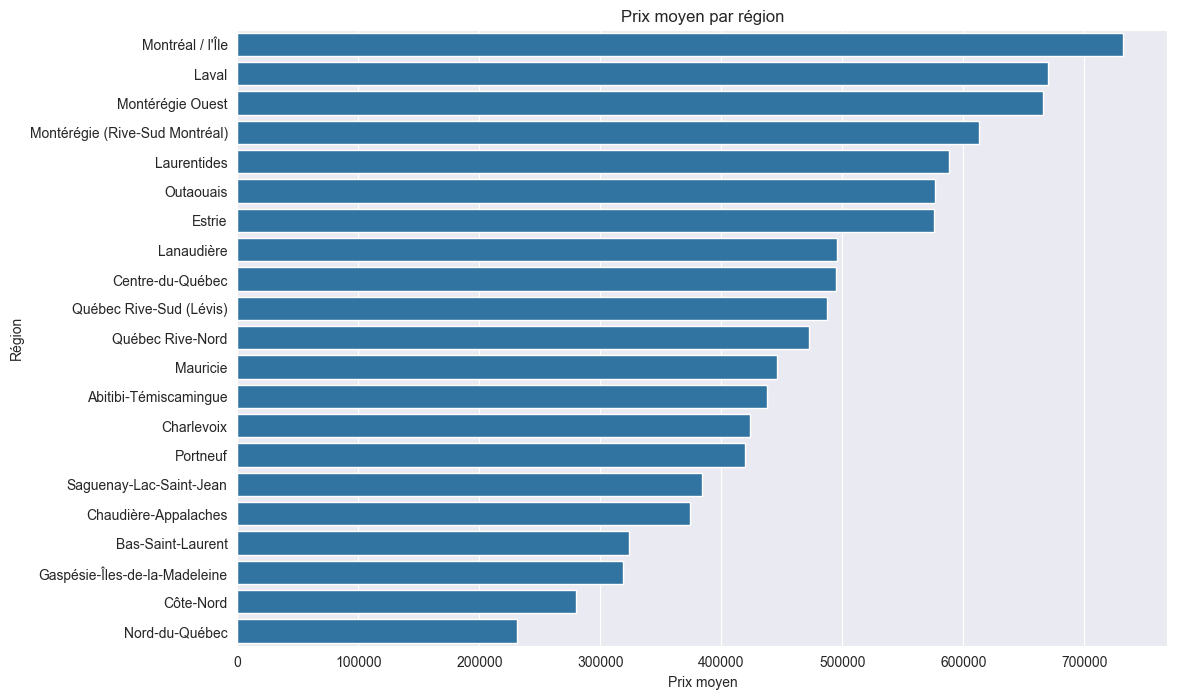

Région avec le prix moyen le plus élevé : Montréal / l'Île


In [61]:
avg_price_by_region = df.groupby("Région")["Prix"].mean()
df_avg_price_by_region = pd.DataFrame({'Région': avg_price_by_region.index, 'Prix moyen': avg_price_by_region.values})

plt.figure(figsize=(12, 8))
sns.barplot(x='Prix moyen', y='Région', data=df_avg_price_by_region.sort_values(by="Prix moyen", ascending=False))
plt.title("Prix moyen par région")
plt.xlabel("Prix moyen")
plt.ylabel("Région")
plt.show()

print(f"Région avec le prix moyen le plus élevé : {avg_price_by_region.idxmax()}")

### 3.5 Pour ce point, on se limite aux annonces ayant au moins 1 chambre et 1 salle de bain. A l’aide d’un graphique, comparer le prix moyen de ces annonces pour chaque r´egion. Quelle r´egion poss`ede le prix moyen le plus ´elev´e pour les annonces avec au moins 1 chambre et 1 salle de bain?

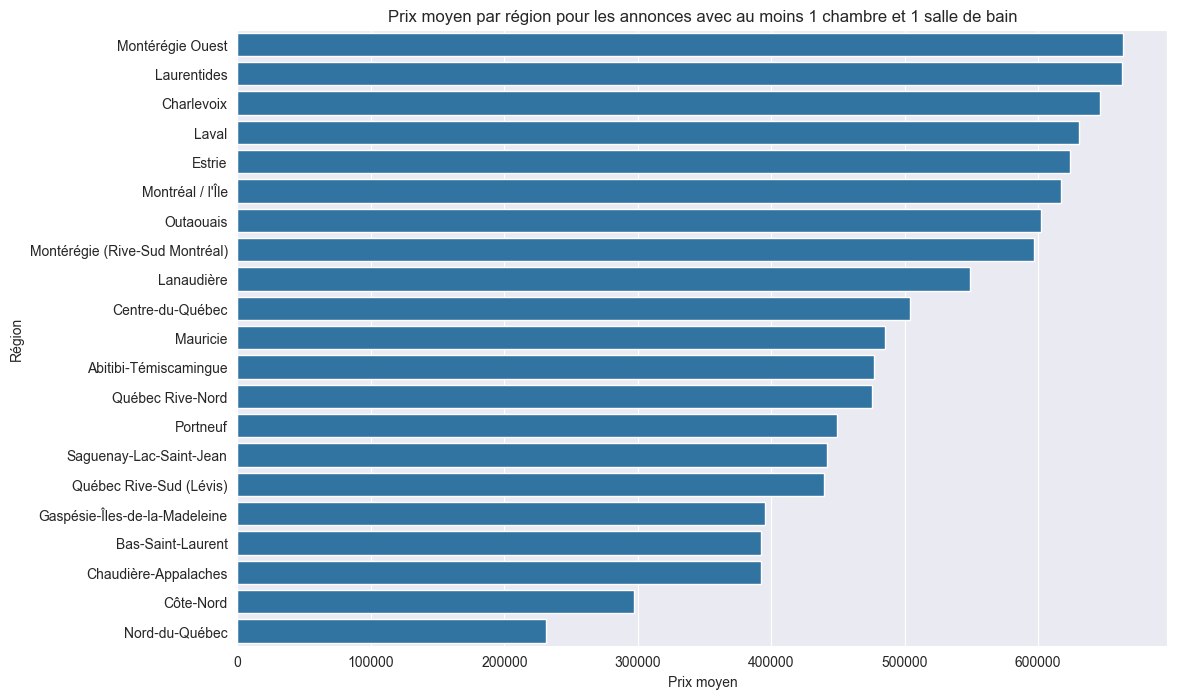

Région avec le prix moyen le plus élevé pour les annonces avec au moins 1 chambre et 1 salle de bain :
 Montérégie Ouest


In [68]:
df_houses = df[(df["Chambres"] >= 1) & (df["Salles de bain"] >= 1)]
df_houses_avg_price_by_region = df_houses.groupby("Région")["Prix"].mean()
df_houses_avg_price_by_region = pd.DataFrame(
    {'Région': df_houses_avg_price_by_region.index, 'Prix moyen': df_houses_avg_price_by_region.values})

plt.figure(figsize=(12, 8))
sns.barplot(x='Prix moyen', y='Région',
            data=df_houses_avg_price_by_region.sort_values(by="Prix moyen", ascending=False))
plt.title("Prix moyen par région pour les annonces avec au moins 1 chambre et 1 salle de bain")
plt.xlabel("Prix moyen")
plt.ylabel("Région")
plt.show()

print(
    f"Région avec le prix moyen le plus élevé pour les annonces avec au moins 1 chambre et 1 salle de bain :\n {df_houses_avg_price_by_region.loc[df_houses_avg_price_by_region['Prix moyen'].idxmax()]['Région']}")


### 3.6 A l’aide d’un graphique, analyser la relation entre le prix des annonces et le nombre de chambres. Y a-t-il un lien quelconque ? Est-ce que la r´egion y joue un rˆole dans cette relation? Peut-on apercevoir des valeurs aberrantes ? Si oui identifiez-les : donnez toutes les valeurs des colonnes de ces valeurs aberrantes.

In [78]:
def find_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    max = df[column] > q3 + (1.5 * iqr)
    min = df[column] < q1 - (1.5 * iqr)
    return df[max | min]


def remove_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    max = df[column] > q3 + (1.5 * iqr)
    min = df[column] < q1 - (1.5 * iqr)
    return df[~(max | min)]

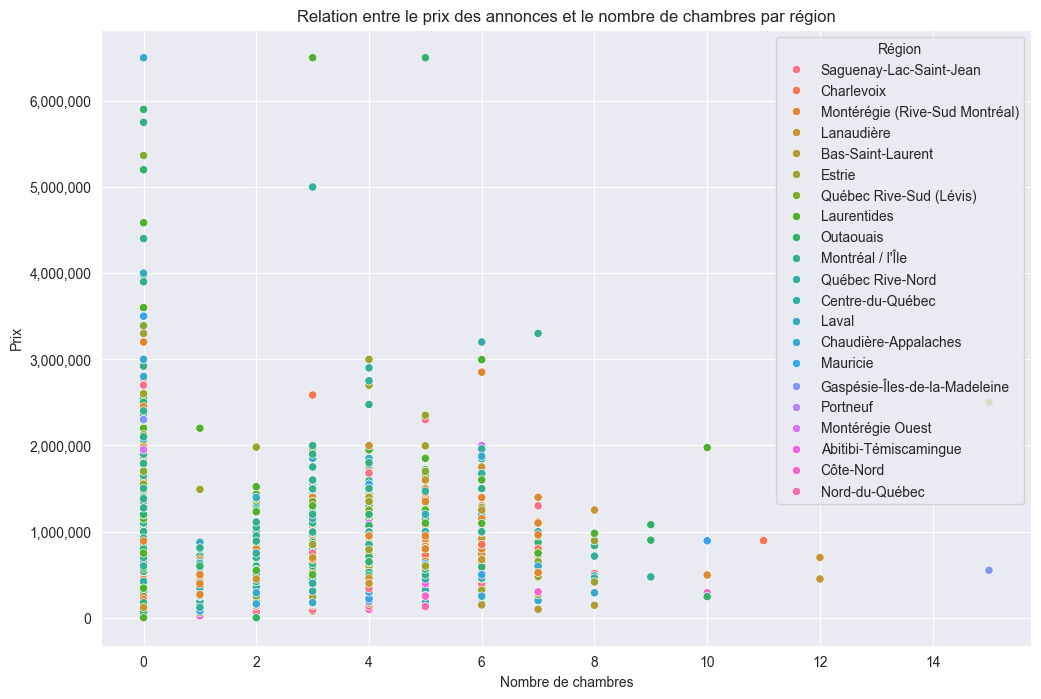

Valeurs aberrantes prix:
[2000000.   1360000.   1250000.   1294000.   2200000.   3300000.
 5200000.   1245000.   1485000.   2699000.   3000000.   1999999.
 1595000.   1325000.   1400000.   1395000.   1590000.   1600000.
 1375000.   1688000.   1299000.   1549000.   1259900.   1995000.
 1658000.   1279000.   1365000.   1249000.   1495000.   2500000.
 1449000.   1399000.   1550000.   1489000.   6500000.   1499000.
 1625000.   2999000.   2550000.   2850000.   1719000.   1750000.
 2295000.   1399999.   2212800.   1669000.   1390000.   1441270.
 1450000.   1229000.   1884014.84 1575000.   1390737.   1354206.6
 1396719.75 1349000.   1598000.   1354361.   1299900.   1273000.
 1434000.   4400000.   1850000.   1385000.   1329999.   1599000.
 1300000.   1220000.   1648000.   2585000.   1295000.   1695000.
 5900000.   1520000.   2299900.   1845000.   1275000.   1548000.
 1725000.   1220400.   1650000.   1279900.   1700000.   3977170.
 1990000.   1398900.   1624900.   1298000.   2199000.   1975000.

In [72]:
from matplotlib.ticker import StrMethodFormatter

plt.figure(figsize=(12, 8))

sns.scatterplot(x='Chambres', y='Prix', hue="Région", data=df)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.title("Relation entre le prix des annonces et le nombre de chambres par région")
plt.xlabel("Nombre de chambres")
plt.ylabel("Prix")
plt.show()

print("Valeurs aberrantes prix:")
print(find_outliers(df, "Prix")["Prix"].unique())

print("Valeurs aberrantes chambres:")
print(find_outliers(df, "Chambres")["Chambres"].unique())



In [73]:
q1 = df["Prix"].quantile(0.25)
q3 = df["Prix"].quantile(0.75)
iqr = q3 - q1
print("Prix")
print(f"Q1 : {q1}")
print(f"Q3 : {q3}")
print(f"IQR : {iqr}")
print(f"Max : {q3 + (1.5 * iqr)}")
print(f"Min : {q1 - (1.5 * iqr)}")

q1 = df["Chambres"].quantile(0.25)
q3 = df["Chambres"].quantile(0.75)
iqr = q3 - q1
print("\nChambres")
print(f"Q1 : {q1}")
print(f"Q3 : {q3}")
print(f"IQR : {iqr}")
print(f"Max : {q3 + (1.5 * iqr)}")
print(f"Min : {q1 - (1.5 * iqr)}")



Prix
Q1 : 320000.0
Q3 : 679000.0
IQR : 359000.0
Max : 1217500.0
Min : -218500.0

Chambres
Q1 : 0.0
Q3 : 3.0
IQR : 3.0
Max : 7.5
Min : -4.5


### 3.7 A l’aide d’un graphique, analyser la relation entre la valeur des taxes municipales annuelles des annonces et la taille du terrain. Y a-t-il un lien quelconque ? Est-ce que la r´egion y joue un rˆole dans cette relation? Peut-on apercevoir des valeurs aberrantes ? Si oui identifiez-les : donnez toutes les valeurs des colonnes de ces valeurs aberrantes.

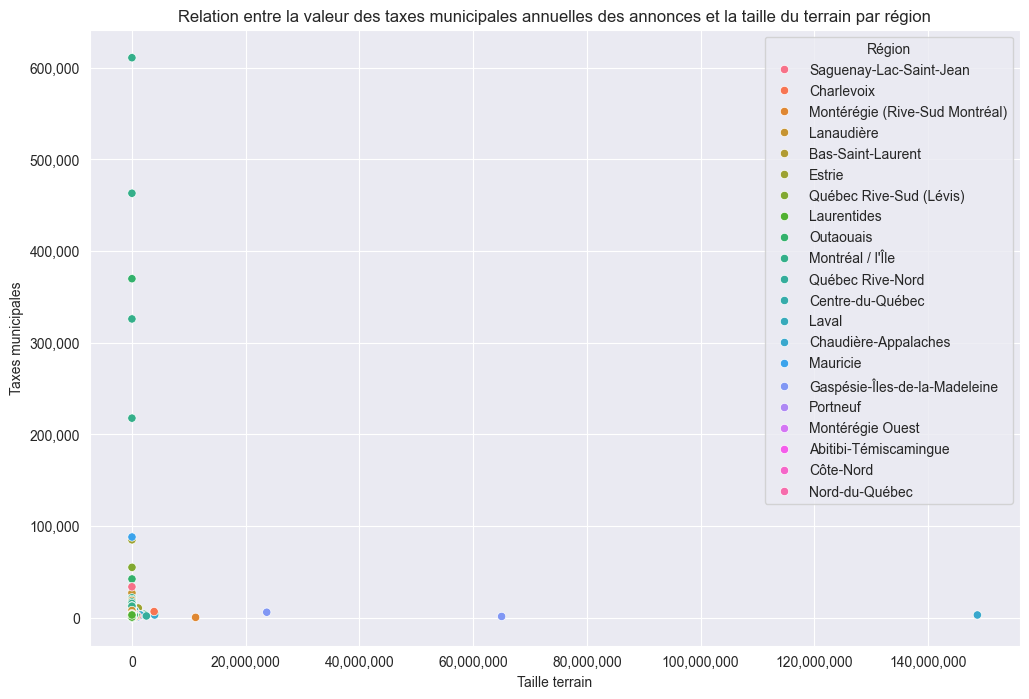

Valeurs aberrantes taxes municipales:
[3.591000e+02 5.791040e+03 6.097000e+03 1.576000e+04 2.132000e+02
 1.590000e+02 7.671300e+03 5.780000e+03 6.320000e+03 4.416100e+02
 6.127000e+03 5.560700e+03 7.764000e+03 5.948000e+03 5.989800e+03
 2.340000e+02 3.309900e+02 5.757000e+03 5.912000e+03 1.954800e+04
 1.893700e+04 3.350300e+02 3.860000e+02 5.344000e+03 5.984000e+03
 6.278440e+03 4.662300e+02 5.000000e+01 7.184000e+03 5.445550e+03
 2.085600e+02 5.825000e+03 4.500000e+02 5.403000e+03 1.040000e+04
 5.227000e+03 5.600000e+03 4.631400e+05 2.813200e+02 5.219710e+03
 5.292340e+03 9.413530e+03 3.960000e+02 8.638000e+03 4.395600e+02
 5.479000e+03 5.272000e+03 9.715000e+03 5.731000e+03 6.335310e+03
 1.370000e+02 3.540000e+02 8.998000e+03 6.007000e+03 1.135469e+04
 5.980000e+03 3.137500e+02 6.517000e+03 5.284000e+03 5.350900e+03
 8.380000e+03 7.329540e+03 8.062000e+03 3.901800e+02 7.000000e+03
 5.371770e+03 6.701350e+03 7.136490e+03 7.560000e+03 6.020790e+03
 8.723640e+03 1.830000e+04 5.574000e+0

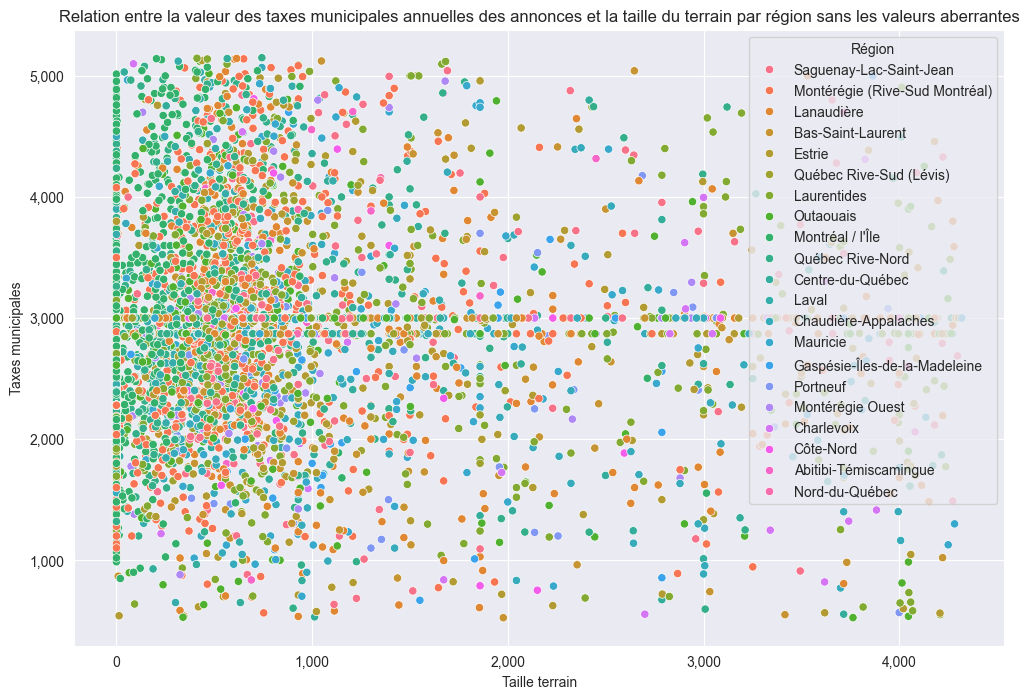

In [79]:
plt.figure(figsize=(12, 8))

sns.scatterplot(x='Taille terrain', y='Taxes municipales', hue="Région", data=df)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.title("Relation entre la valeur des taxes municipales annuelles des annonces et la taille du terrain par région")
plt.xlabel("Taille terrain")
plt.ylabel("Taxes municipales")
plt.show()

print("Valeurs aberrantes taxes municipales:")
print(find_outliers(df, "Taxes municipales")["Taxes municipales"].unique())

print("Valeurs aberrantes taille terrain:")
print(find_outliers(df, "Taille terrain")["Taille terrain"].unique())

plt.figure(figsize=(12, 8))
outliers_taxes = remove_outliers(df, "Taxes municipales")
outliers_taille = remove_outliers(outliers_taxes, "Taille terrain")
sns.scatterplot(x='Taille terrain', y='Taxes municipales', hue="Région", data=outliers_taille)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.title(
    "Relation entre la valeur des taxes municipales annuelles des annonces et la taille du terrain par région sans les valeurs aberrantes")
plt.xlabel("Taille terrain")
plt.ylabel("Taxes municipales")
plt.show()




In [81]:
q1 = df["Taxes municipales"].quantile(0.25)
q3 = df["Taxes municipales"].quantile(0.75)
iqr = q3 - q1
print("Taxes municipales")
print(f"Q1 : {q1}")
print(f"Q3 : {q3}")
print(f"IQR : {iqr}")
print(f"Max : {q3 + (1.5 * iqr)}")
print(f"Min : {q1 - (1.5 * iqr)}")

q1 = df["Taille terrain"].quantile(0.25)
q3 = df["Taille terrain"].quantile(0.75)
iqr = q3 - q1
print("\nTaille terrain")
print(f"Q1 : {q1}")
print(f"Q3 : {q3}")
print(f"IQR : {iqr}")
print(f"Max : {q3 + (1.5 * iqr)}")
print(f"Min : {q1 - (1.5 * iqr)}")


Taxes municipales
Q1 : 2258.19
Q3 : 3415.16
IQR : 1156.9699999999998
Max : 5150.615
Min : 522.7350000000004

Taille terrain
Q1 : 248.16
Q3 : 2043.9
IQR : 1795.74
Max : 4737.51
Min : -2445.4500000000003


### 3.8 A l’aide d’un graphique, analyser la relation entre la valeur des taxes municipales annuelles des annonces et le prix. Il y a-t-il un lien quelconque ? Est-ce que la r´egion y joue un rˆole dans cette relation? Peut-on apercevoir des valeurs aberrantes ? Si oui identifiez-les : donnez toutes les valeurs des colonnes de ces valeurs aberrantes.

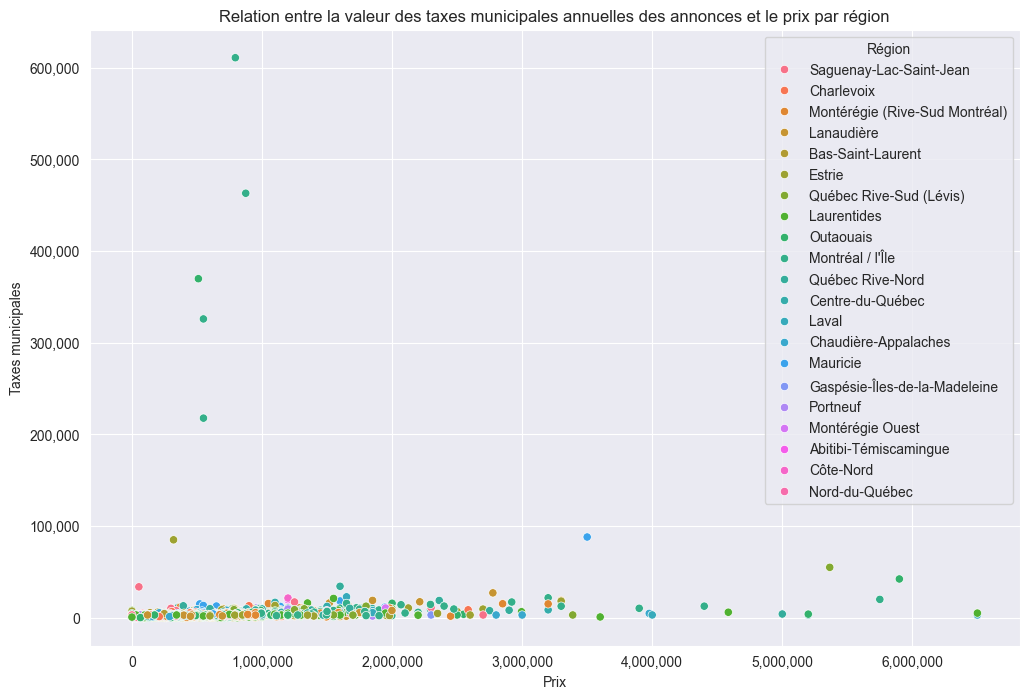

Valeurs aberrantes taxes municipales:
[3.591000e+02 5.791040e+03 6.097000e+03 1.576000e+04 2.132000e+02
 1.590000e+02 7.671300e+03 5.780000e+03 6.320000e+03 4.416100e+02
 6.127000e+03 5.560700e+03 7.764000e+03 5.948000e+03 5.989800e+03
 2.340000e+02 3.309900e+02 5.757000e+03 5.912000e+03 1.954800e+04
 1.893700e+04 3.350300e+02 3.860000e+02 5.344000e+03 5.984000e+03
 6.278440e+03 4.662300e+02 5.000000e+01 7.184000e+03 5.445550e+03
 2.085600e+02 5.825000e+03 4.500000e+02 5.403000e+03 1.040000e+04
 5.227000e+03 5.600000e+03 4.631400e+05 2.813200e+02 5.219710e+03
 5.292340e+03 9.413530e+03 3.960000e+02 8.638000e+03 4.395600e+02
 5.479000e+03 5.272000e+03 9.715000e+03 5.731000e+03 6.335310e+03
 1.370000e+02 3.540000e+02 8.998000e+03 6.007000e+03 1.135469e+04
 5.980000e+03 3.137500e+02 6.517000e+03 5.284000e+03 5.350900e+03
 8.380000e+03 7.329540e+03 8.062000e+03 3.901800e+02 7.000000e+03
 5.371770e+03 6.701350e+03 7.136490e+03 7.560000e+03 6.020790e+03
 8.723640e+03 1.830000e+04 5.574000e+0

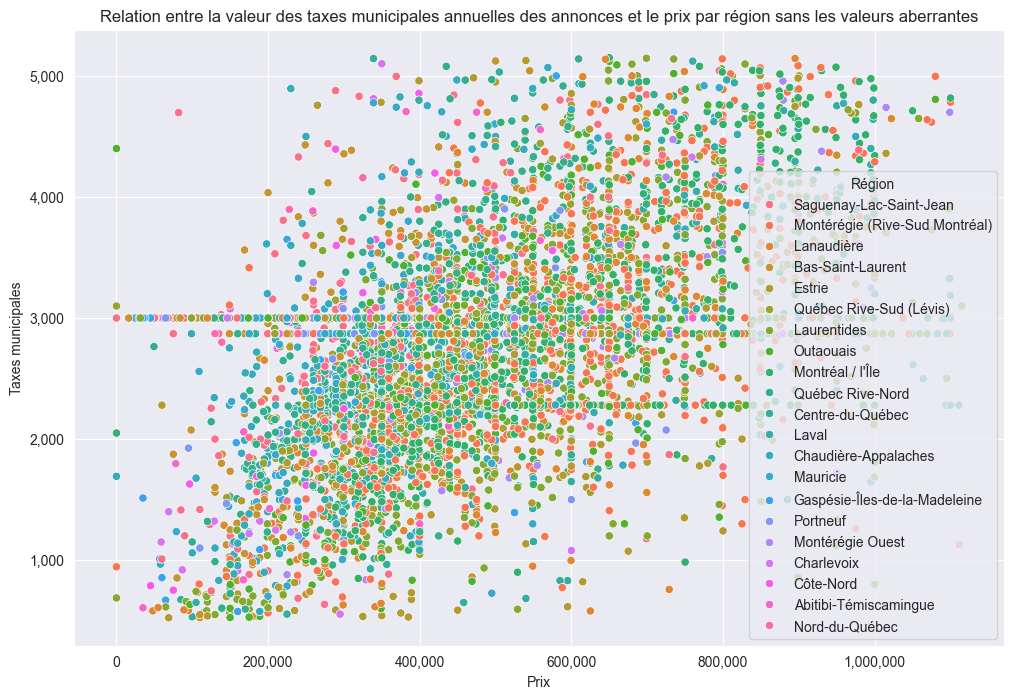

In [83]:
plt.figure(figsize=(12, 8))

sns.scatterplot(x='Prix', y='Taxes municipales', hue="Région", data=df)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.title("Relation entre la valeur des taxes municipales annuelles des annonces et le prix par région")
plt.xlabel("Prix")
plt.ylabel("Taxes municipales")
plt.show()

print("Valeurs aberrantes taxes municipales:")
print(find_outliers(df, "Taxes municipales")["Taxes municipales"].unique())

print("Valeurs aberrantes prix:")
print(find_outliers(df, "Prix")["Prix"].unique())

plt.figure(figsize=(12, 8))
outliers_taxes = remove_outliers(df, "Taxes municipales")
outliers_prix = remove_outliers(outliers_taxes, "Prix")
sns.scatterplot(x='Prix', y='Taxes municipales', hue="Région", data=outliers_prix)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.title(
    "Relation entre la valeur des taxes municipales annuelles des annonces et le prix par région sans les valeurs aberrantes")
plt.xlabel("Prix")
plt.ylabel("Taxes municipales")
plt.show()


In [84]:
q1 = df["Taxes municipales"].quantile(0.25)
q3 = df["Taxes municipales"].quantile(0.75)
iqr = q3 - q1
print("Taxes municipales")
print(f"Q1 : {q1}")
print(f"Q3 : {q3}")
print(f"IQR : {iqr}")
print(f"Max : {q3 + (1.5 * iqr)}")
print(f"Min : {q1 - (1.5 * iqr)}")

q1 = df["Prix"].quantile(0.25)
q3 = df["Prix"].quantile(0.75)
iqr = q3 - q1
print("\nPrix")
print(f"Q1 : {q1}")
print(f"Q3 : {q3}")
print(f"IQR : {iqr}")
print(f"Max : {q3 + (1.5 * iqr)}")
print(f"Min : {q1 - (1.5 * iqr)}")


Taxes municipales
Q1 : 2258.19
Q3 : 3415.16
IQR : 1156.9699999999998
Max : 5150.615
Min : 522.7350000000004

Prix
Q1 : 320000.0
Q3 : 679000.0
IQR : 359000.0
Max : 1217500.0
Min : -218500.0


### 3.9 On s’int´eresse pour cette question aux annonces qui ont un prix affich´e de moins de 1 million de $, pour toutes les r´egions. Dessiner dans un mˆeme graphique un boxplot repr´esentant la r´epartition de prix par r´egion. Analyser de mani`ere d´etaill´ee le graphique obtenu.

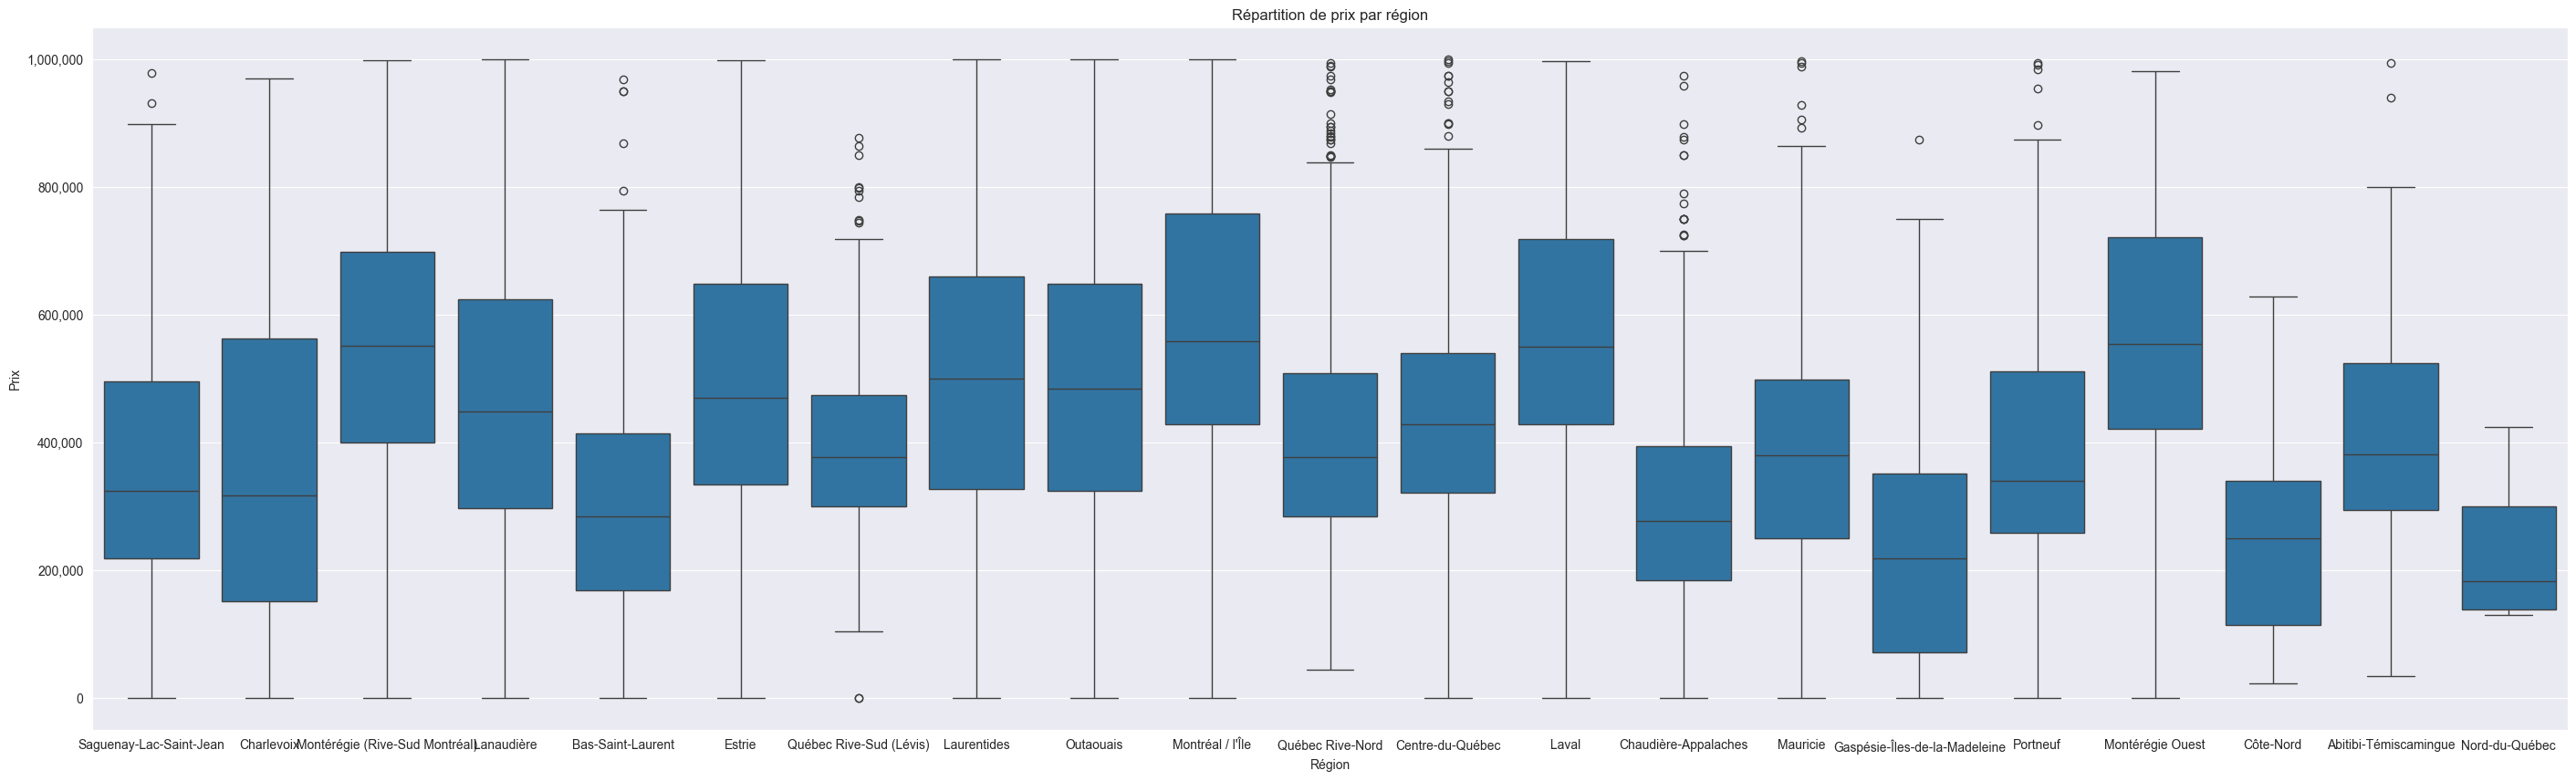

In [85]:
plt.figure(figsize=(35, 10))

sns.boxplot(x='Région', y='Prix', data=df[df["Prix"] < 1000000])
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.title("Répartition de prix par région")
plt.xlabel("Région")
plt.ylabel("Prix")
plt.show()


### 3.10 On s’int´eresse pour cette question aux maisons de 2 chambres au moins et une salle de bain au moins et qui coˆute moins de 1 million de $, pour toutes les r´egions. Dessiner dans un mˆeme graphique un boxplot repr´esentant la r´epartition de prix par r´egions. Analyser de mani`ere d´etaill´ee le graphique obtenu. Est-ce qu’il y a des diff´erences entre ce graphique et celui de la question pr´ec´edente ? Si oui donner en 4.

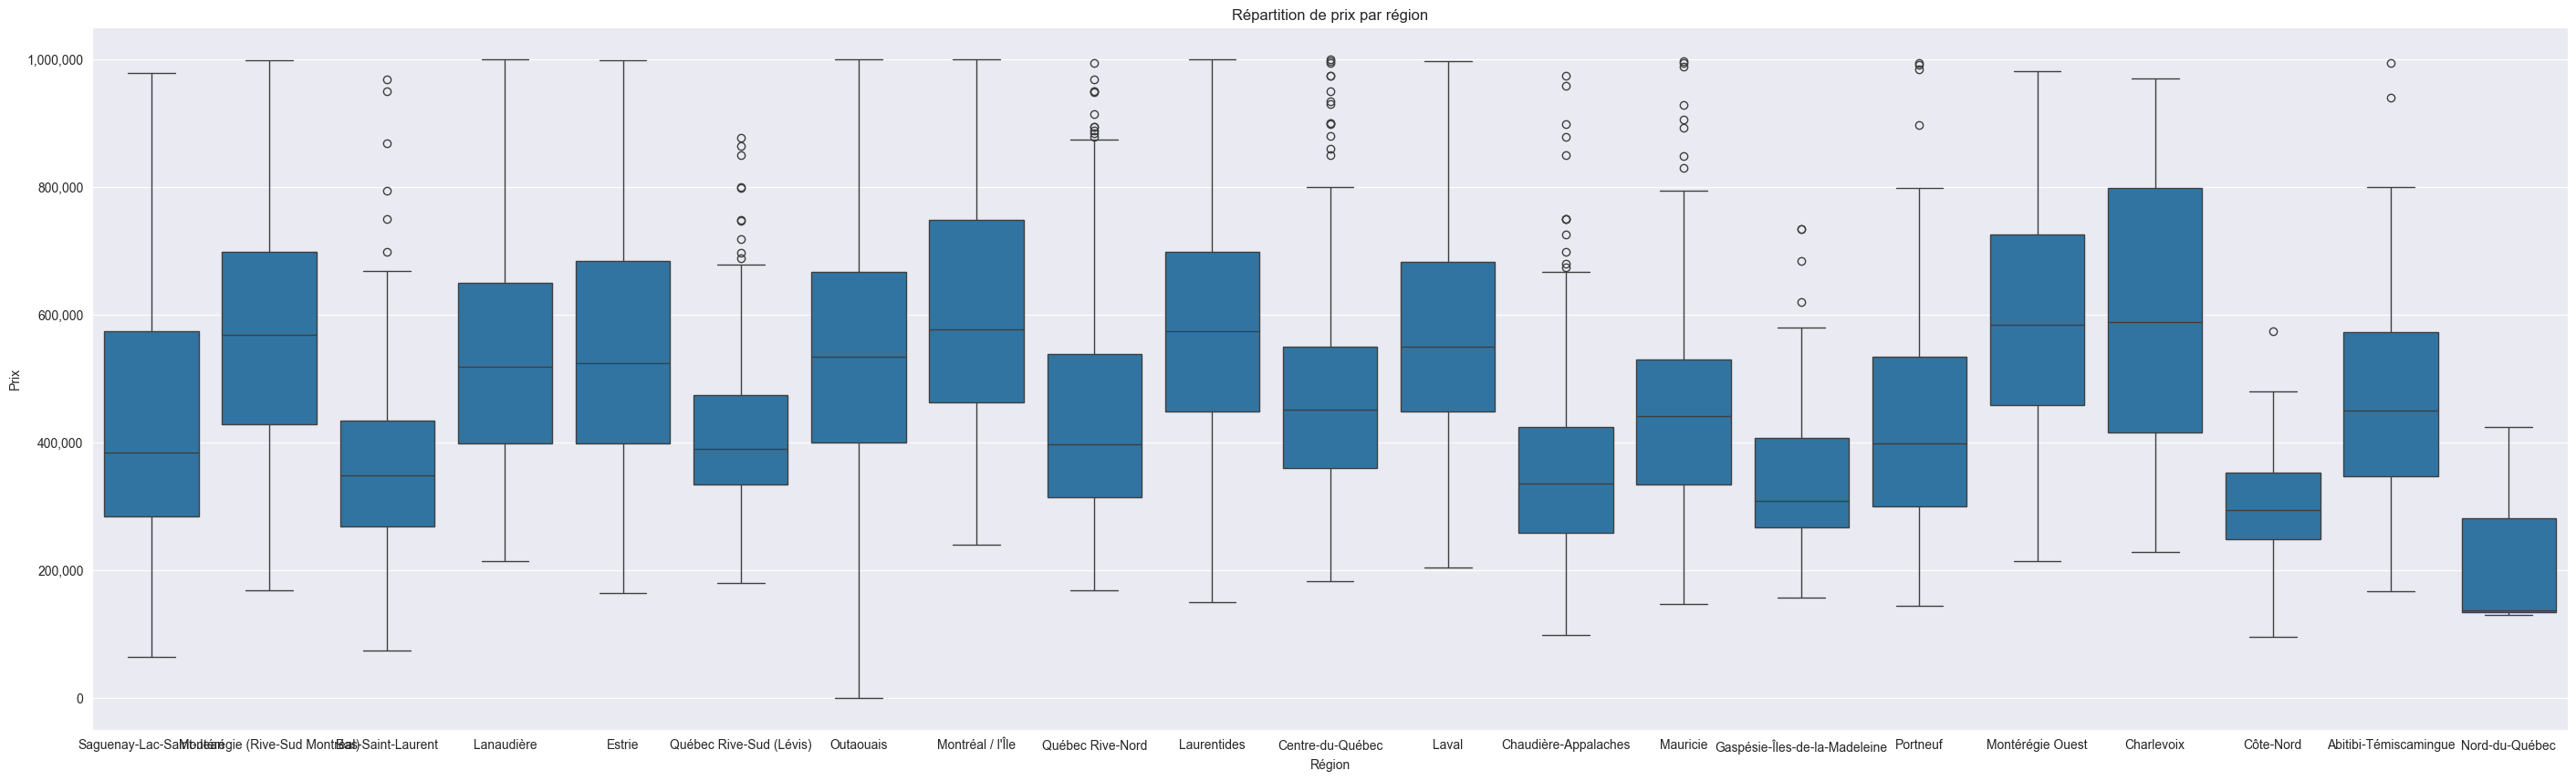

In [87]:
plt.figure(figsize=(35, 10))

sns.boxplot(x='Région', y='Prix', data=df[(df["Prix"] < 1000000) & (df["Chambres"] >= 2) & (df["Salles de bain"] >= 1)])
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.title("Répartition de prix par région")
plt.xlabel("Région")
plt.ylabel("Prix")
plt.show()


### 3.11 En un seul graphique, pr´esenter une analyse bivari´ee de toutes les colonnes num´eriques de votre jeu de donn´ees. Analyser en d´etail le graphique obtenu.

<Figure size 3000x3000 with 0 Axes>

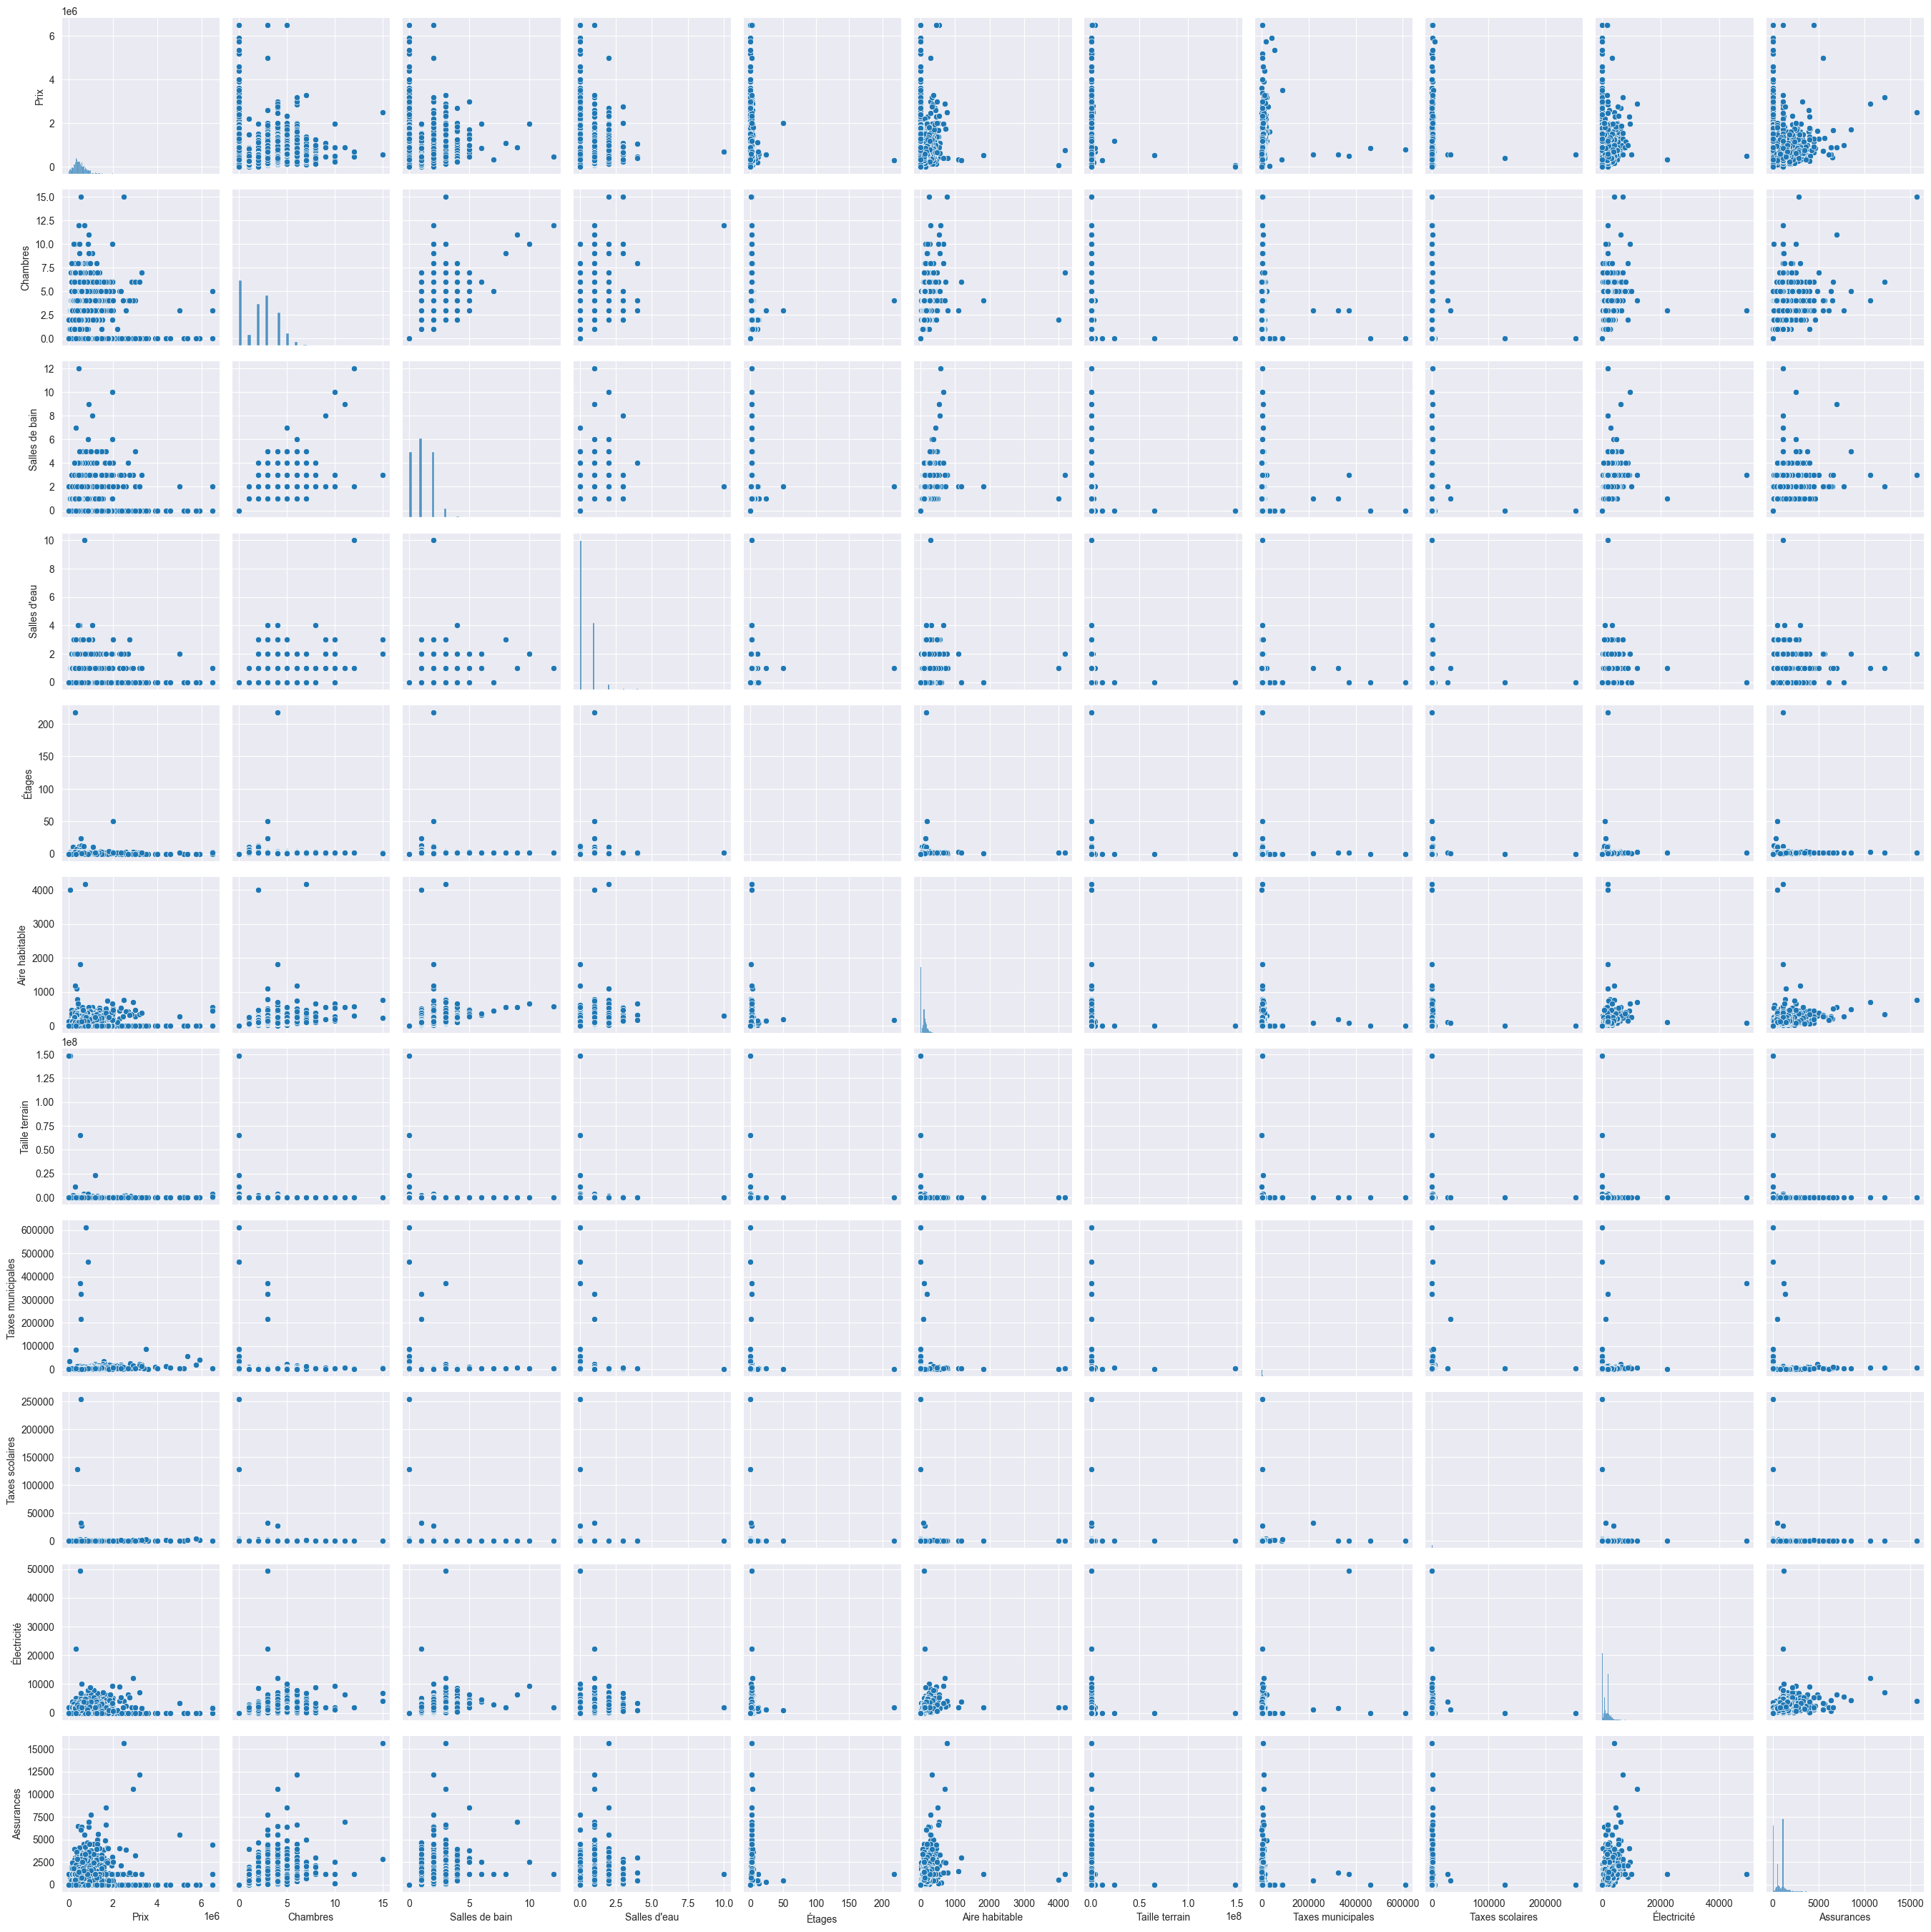

In [88]:
plt.figure(figsize=(30, 30))
sns.pairplot(df.select_dtypes(include=['float64', 'int64']))
plt.savefig("pairplot-pt1-3-11.svg")
plt.show()


## 4 Algorithmes de regression
### 4.1 Dans la matrice de corr´elation pr´esent´ee ci-dessus, identifier 2 variables diff´erentes qui ont le plus haut coefficient de corr´elation. Concevez un mod`ele de r´egression lin´eaire dont l’une des valeurs est a` pr´edire et l’autre est la valeur d’entr´ee. Le mod`ele de r´egression construit n’est autre qu’une droite. Vous devez repr´esenter cette droite dans un graphique, ainsi que les points de donn´ees qui repr´esentent les 2 variables. Est-ce que la droite telle que pr´esent´ee sur votre graphique fait une bonne approximation de vos points/donn´ees? V´erifier votre r´eponse avec les donn´ees de test.

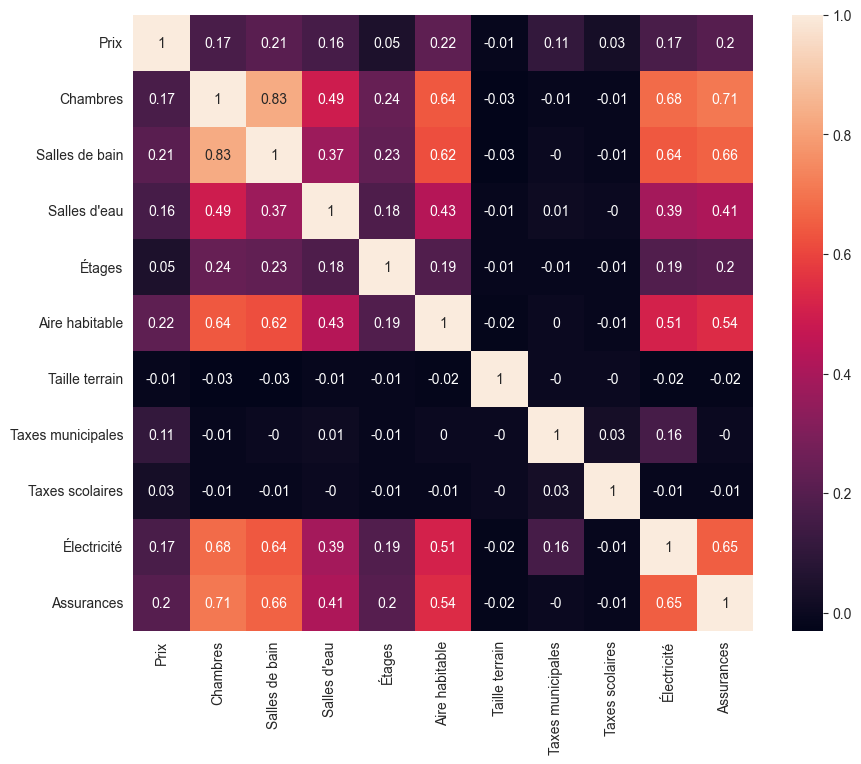

Chambres        Salles de bain    0.83
                Assurances        0.71
Salles de bain  Chambres          0.83
Assurances      Chambres          0.71
dtype: float64


In [89]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numeric_df.corr().round(2)

plt.figure(figsize=(10, 8))
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

correlation_target = abs(correlation_matrix.unstack())
print(correlation_target[(correlation_target > 0.7) & (correlation_target != 1)])

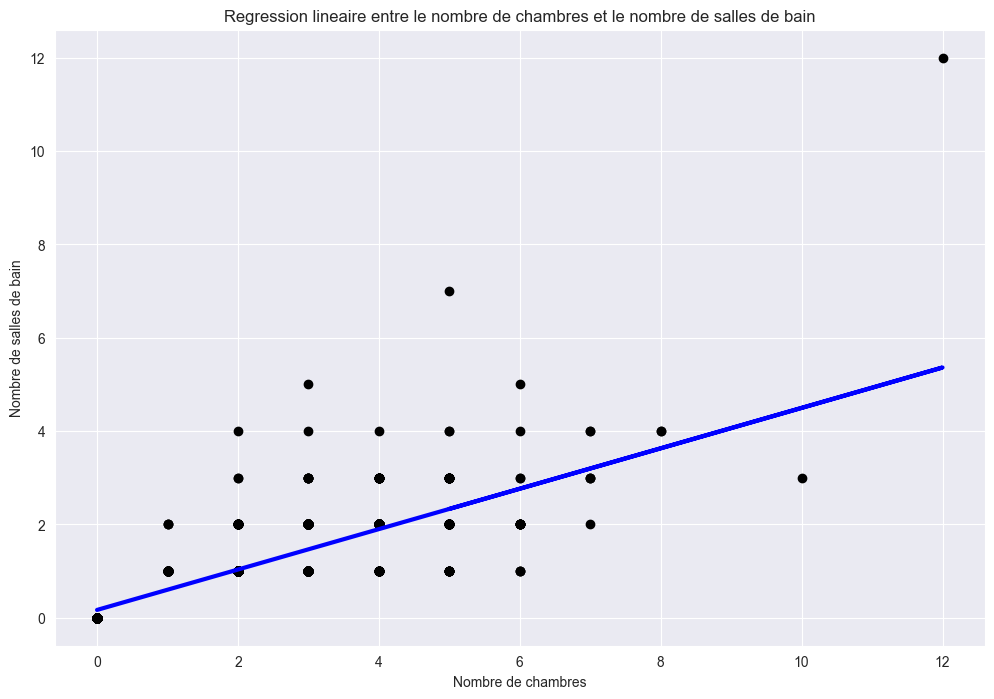

R2 : 0.6930308941720327
RMSE : 0.5568620602205876
R2 ajuste : 0.6927453415154485


In [93]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = df[["Chambres"]]
y = df[["Salles de bain"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

plt.figure(figsize=(12, 8))
plt.scatter(X_test, y_test, color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)
plt.title("Regression lineaire entre le nombre de chambres et le nombre de salles de bain")
plt.xlabel("Nombre de chambres")
plt.ylabel("Nombre de salles de bain")
plt.show()

#r2
print(f"R2 : {model.score(X_test, y_test)}")
#rmse
print(f"RMSE : {np.sqrt(np.mean((y_pred - y_test) ** 2))}")
#r2ajuste
print(f"R2 ajuste : {1 - (1 - model.score(X_test, y_test)) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)}")

### 4.2 Dans cette question, on s’int´eresse a` pr´edire si le prix d’une annonce sera sup´erieur ou inf´erieur a` 350000$ en fonction de la r´egion, du nombre de chambres, le nombre de salles de bain, le nombre de salles d’eau, le nombre d’´etages, la superficie de l’aire habitable, la taille du terrain, les taxes municipales et les taxes scolaires. Concevez un mod`ele de r´egression qui permet de faire cette pr´ediction et ´evaluer votre mod`ele.

Accuracy : 0.8022284122562674
Confusion matrix :
 [[230 144]
 [ 69 634]]
F1 score : 0.8561782579338284


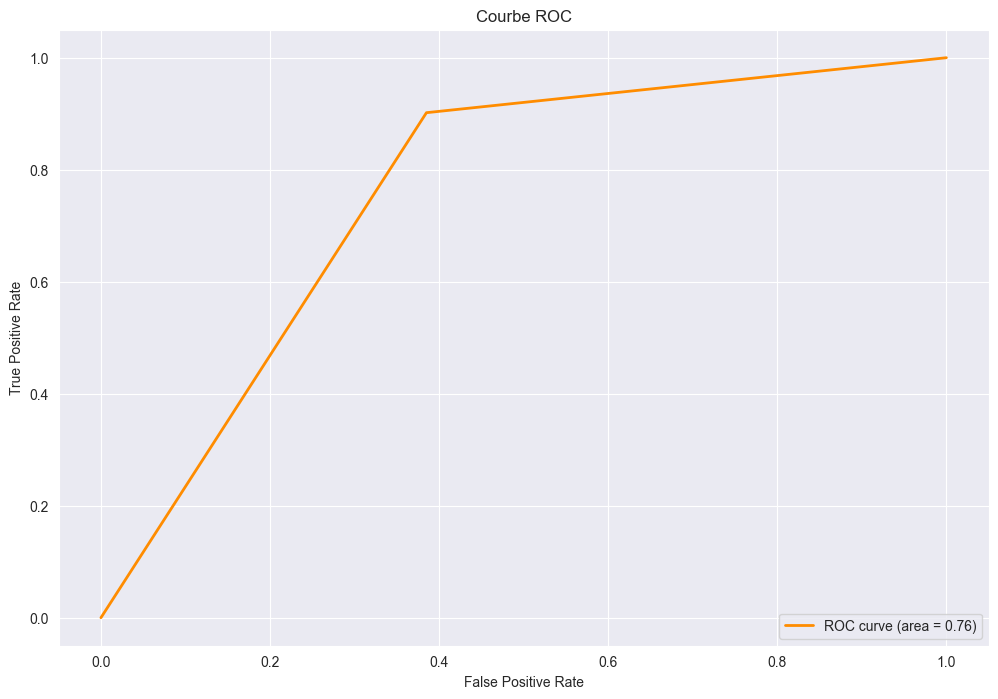

In [97]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, auc

df["Prix > 350000"] = df["Prix"] > 350000

X = df[["Chambres", "Salles de bain", "Salles d'eau", "Étages", "Aire habitable", "Taille terrain",
        "Taxes municipales", "Taxes scolaires", "Électricité", "Assurances"]]
y = df["Prix > 350000"]

encoder = OneHotEncoder()
encoder.fit(df[["Région"]])
X = np.concatenate((X, encoder.transform(df[["Région"]]).toarray()), axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy : {accuracy}")
print(f"Confusion matrix :\n {confusion_matrix(y_test, y_pred)}")
print(f"F1 score : {f1_score(y_test, y_pred)}")

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)

plt.title("Courbe ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()




### 4.3 Dans cette question, on s’int´eresse a` pr´edire le prix d’une annonce en fonction de la r´egion, du nombre de chambres, le nombre de salles de bain, le nombre de salles d’eau, le nombre d’´etages, la superficie de l’aire habitable, la taille du terrain, les taxes municipales et les taxes scolaires. Concevez un mod`ele de r´egression qui permet de faire cette pr´ediction et ´evaluer votre mod`ele.

In [105]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

numeric_columns = ["Chambres", "Salles de bain", "Salles d'eau", "Étages", "Aire habitable", "Taille terrain",
                   "Taxes municipales", "Taxes scolaires"]

df_no_outliers = df.copy()

for column in numeric_columns:
    df_no_outliers = df_no_outliers[~df_no_outliers.index.isin(find_outliers(df_no_outliers, column).index)]

X = df_no_outliers[["Chambres", "Salles de bain", "Salles d'eau", "Étages", "Aire habitable", "Taille terrain",
                    "Taxes municipales", "Taxes scolaires"]]
y = df_no_outliers["Prix"]

encoder = OneHotEncoder()
encoder.fit(df_no_outliers[["Région"]])
X = np.concatenate((X, encoder.transform(df_no_outliers[["Région"]]).toarray()), axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = model.score(X_test, y_test)
print(f"R2 : {r2}")
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE : {rmse}")
r2_ajuste = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)
print(f"R2 ajuste : {r2_ajuste}")

R2 : 0.4728501184576904
RMSE : 161918.91542501395
R2 ajuste : 0.45170579402514965


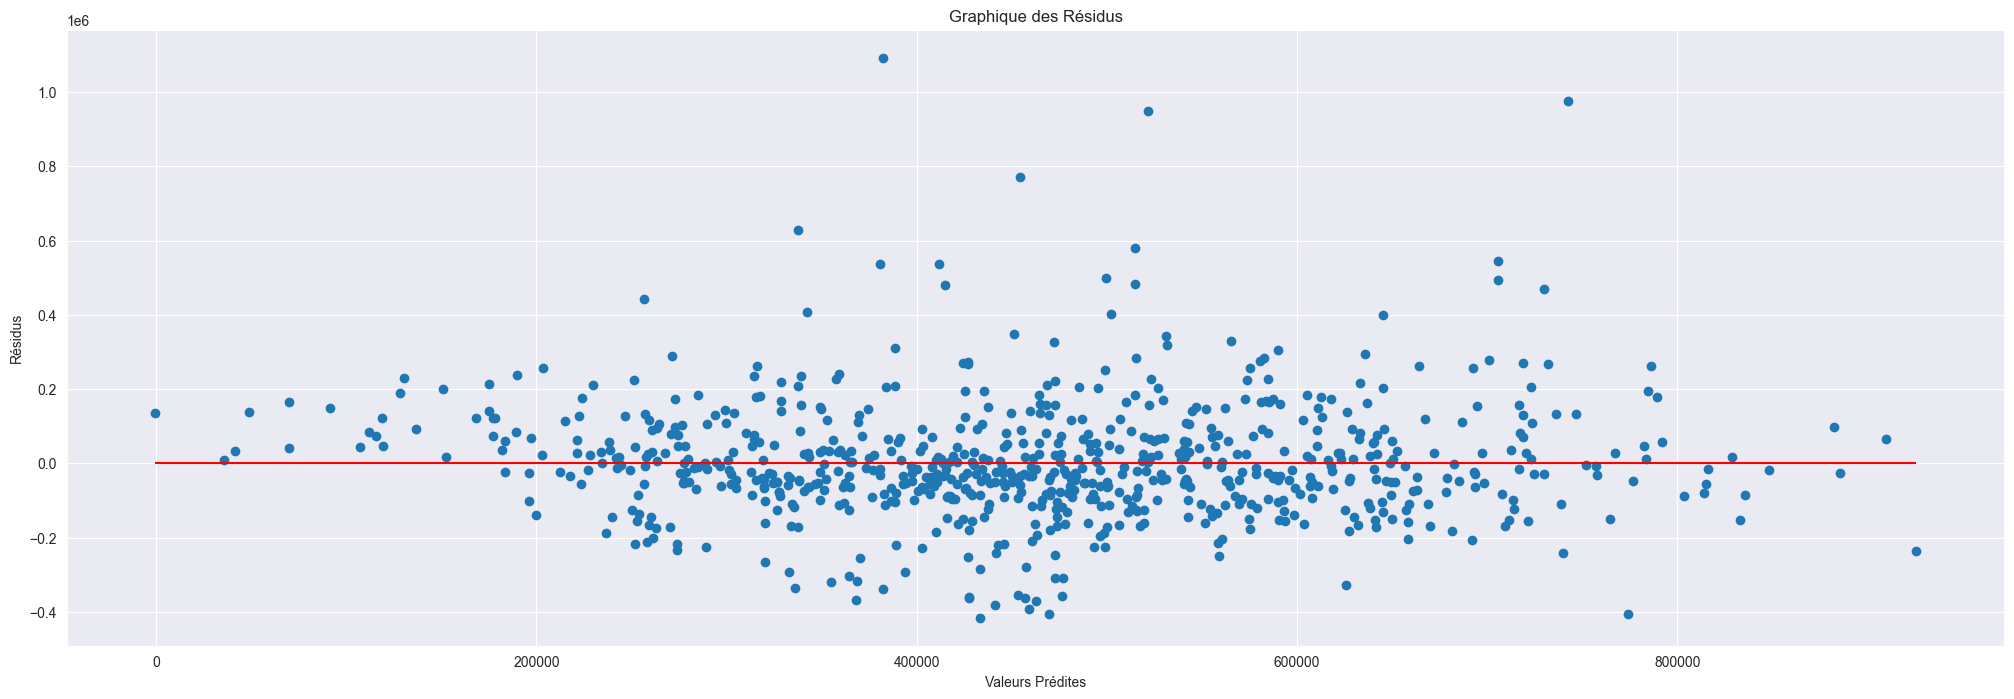

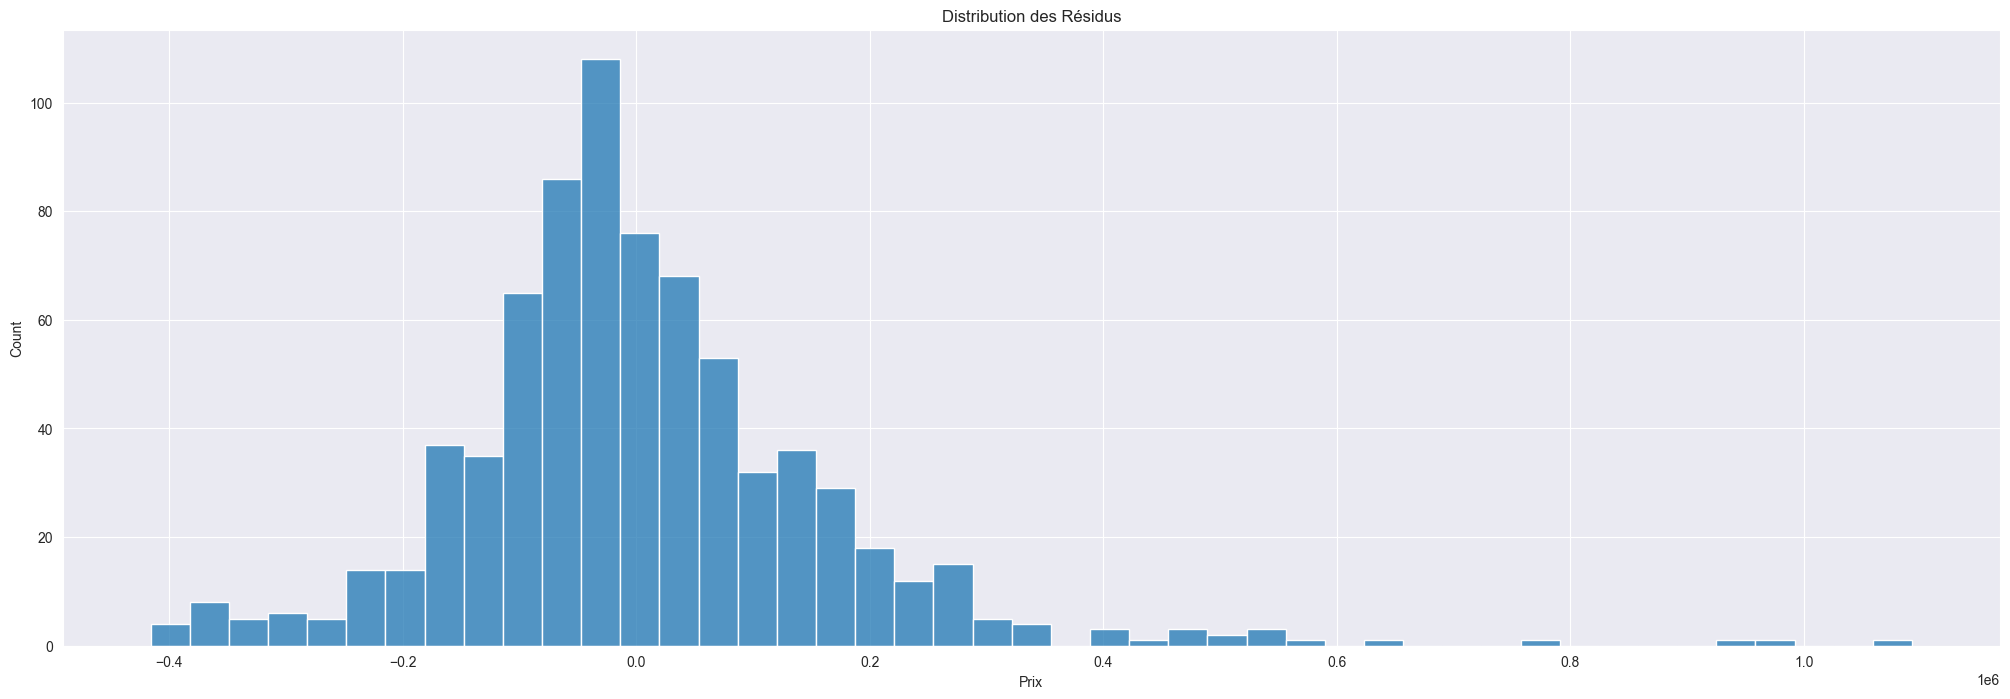

In [107]:
residuals = y_test - y_pred

plt.figure(figsize=(25, 8))
plt.scatter(y_pred, residuals)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='red')
plt.xlabel('Valeurs Prédites')
plt.ylabel('Résidus')
plt.title('Graphique des Résidus')
plt.show()

plt.figure(figsize=(25, 8))
sns.histplot(residuals)
plt.title('Distribution des Résidus')
plt.show()



### 4.4 Le couple Formidable aimerait vendre 2 de ses propri´et´es. En vous servant de votre mod`ele construit ci-dessus, a` combien est estim´e le prix de vente de chacune des deux propri´et´es ? Voici les caract´eristiques :

• Propri´et´e 1: r´egion: Qu´ebec Rive-Nord, nombre de chambres: 3, nombre de salles de bain: 2, nombre de salles d’eau: 1, nombre d’´etages: 2, superficie de l’aire habitable: 1700.2 pi 2 , taille du terrain: 5060 pi 2 , taxes municipales: 4272,39$, taxes scolaires: 411,06$, ´electricit´e: 3 584,00 $, assurances 110,38 $.

• Propri´et´e 2: ville: Ferme-Neuve, r´egion: Laurentides, taille du terrain 8021.06 pi 2 , taxes municipales: 2 324,75 $, taxes scolaires: 65,59$

In [108]:

props = [{
    "Chambres": 3,
    "Salles de bain": 2,
    "Salles d'eau": 1,
    "Étages": 2,
    "Aire habitable": 1700.2 * 0.092903,
    "Taille terrain": 5060 * 0.092903,
    "Taxes municipales": 4272.39,
    "Taxes scolaires": 411.06,
    "Région": "Québec Rive-Nord"
}, {
    "Chambres": np.nan,
    "Salles de bain": np.nan,
    "Salles d'eau": np.nan,
    "Étages": np.nan,
    "Aire habitable": np.nan,
    "Taille terrain": 8021.06 * 0.092903,
    "Taxes municipales": 2324.75,
    "Taxes scolaires": 65.59,
    "Région": "Laurentides",
}]

df_prop = pd.DataFrame(props)

num_col = ["Chambres", "Salles de bain", "Salles d'eau", "Étages", "Aire habitable", "Taille terrain",
           "Taxes municipales", "Taxes scolaires"]

df_prop[num_col] = df_prop[num_col].fillna(df_prop[num_col].median())

encoded_region = encoder.transform(df_prop[["Région"]]).toarray()

df_prop_encoded = np.concatenate(
    (df_prop[["Chambres", "Salles de bain", "Salles d'eau", "Étages", "Aire habitable", "Taille terrain",
              "Taxes municipales", "Taxes scolaires"]], encoded_region), axis=1)

df_prop_encoded = scaler.transform(df_prop_encoded)

y_pred = model.predict(df_prop_encoded)

print(f"Propriété 1 : {y_pred[0]}")
print(f"Propriété 2 : {y_pred[1]}")


Propriété 1 : 651464.9249789726
Propriété 2 : 480160.92497897265


In [ ]:
print(f"Nombre de ville : {df['Ville'].nunique()}")

### 5. Sans toutefois impl´ementer, pensez-vous que rajouter la ville dans vos 2 derniers mod`eles de r´egression con¸cue am´eliorerait la pr´ediction ? Justifiez votre r´eponse (un graphique ou un calcul).

In [112]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols("Prix ~ Ville", data=df_no_outliers).fit()

anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                sum_sq      df         F        PR(>F)
Ville     9.598214e+13   779.0  2.557173  1.410049e-79
Residual  2.041991e+14  4238.0       NaN           NaN
